# Imports

In [36]:
!which jupyter
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
import re
from scipy.stats import mode as mode
import matplotlib.pyplot as plt
import pickle
pd.set_option('display.max_columns', 100)

/home/ubuntu/thesis_env2/bin/jupyter


In [4]:
# NER File
df_ner = pd.read_pickle('./data/df_ner_matched_210913.pickle')
print(len(df_ner))

# Sentiment Analysis
df_sent = pd.read_pickle('./data/df_sentiment.pickle')
df_sent['finbert'] = df_sent['finbert'].str.upper()

# measure of if all sentiment agree
sentiment_match = np.array(df_sent[['finbert', 'distilbert', 'roberta']])
sentiment_match = np.all(np.equal(sentiment_match, sentiment_match[:,:1]), axis=1)
df_sent['sentiment_match'] = sentiment_match

# most common sentiment
df_sent['sentiment'] = df_sent.apply(lambda x: mode([x['distilbert'], x['finbert'], x['roberta']])[0][0], axis=1)
print(len(df_sent))

# Topics
df_topics = pd.read_pickle("./data/df_with_topics")
df_topics['topic_label_str'] = ['_'.join(map(str, l)) for l in df_topics['topic_label']]
print(len(df_topics))

# Topics - manual defined topics
df_topics_manual = pd.read_pickle('df_doc_embeddings.pickle')
print(len(df_topics_manual))

369045
365200
365200
365200


In [6]:
df_ner.head(1)

,author,date,domain,title,url,content,topic_area,org_names,filtered_names,filtered_names_match,filtered_names_titles_match
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,"[BA, Boeing, CAT, CMI, Caterpillar, Cummins In...","[Boeing, Caterpillar, Cummins Inc, Deere & Com...","[Caterpillar Inc., Cummins Inc., Deere & Compa...",[]


In [7]:
df_sent.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,distilbert,finbert,roberta,sentiment_match,sentiment
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,POSITIVE,NEUTRAL,POSITIVE,False,POSITIVE


In [8]:
df_sent['sentiment'].value_counts(normalize=True)

NEGATIVE    0.630411
POSITIVE    0.369354
            0.000233
too_long    0.000003
Name: sentiment, dtype: float64

In [9]:
df_topics.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,topic_id,topic_label,topic_score,topic_score_rating,topic_words,primary_topic,secondary_topics,topic_label_str
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,970,,0.437342,low,"[caterpillar, ibe, fourthquarter, secondquarte...",,,


In [11]:
df_topics_manual.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,content_lemma,doc_embedding,blockchain,digitization,machine_learne,cloud,iot,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,end year corner past time think positioning fo...,"[-0.10415985, 0.034574475, -0.018250903, 0.040...",0.64344,0.492892,0.579234,0.571812,0.521615,0.453935,0.221586,0.588197,0.209348,0.51657,0.274569,0.142759,0.503211,0.464359,0.674917


In [88]:
df_combined = pd.merge(df_sent, df_topics[['topic_id', 'topic_label', 'topic_label_str', 'topic_score', 'topic_words', 'primary_topic']], how='left', left_index=True, right_index=True)
df_combined = pd.merge(df_combined, df_ner[['filtered_names_match', 'filtered_names_titles_match']], how='left', left_index=True, right_index=True)
df_combined['nb_companies'] = df_combined['filtered_names_match'].apply(lambda x: len(x))
df_combined['nb_companies_title'] = df_combined['filtered_names_titles_match'].apply(lambda x: len(x))
df_combined = pd.merge(df_combined, df_topics_manual[['blockchain', 'digitization', 'machine_learne', 'cloud', 'iot', 'store_closure', 'delivery', 'redundancy', 'costcutte', 'flight', 'supply_chain', 'shutdown', 'outsourcing', 'workfromhome', 'diversification']], 
                       how='left', left_index=True, right_index=True)
df_combined = df_combined[df_combined['sentiment'] != ""]
df_combined = df_combined[df_combined['sentiment'] != 'too_long']
print(len(df_combined[df_combined['topic_label_str'] != ""]))

303685


In [90]:
df_combined.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,distilbert,finbert,roberta,sentiment_match,sentiment,topic_id,topic_label,topic_label_str,topic_score,topic_words,primary_topic,filtered_names_match,filtered_names_titles_match,nb_companies,nb_companies_title,blockchain,digitization,machine_learne,cloud,iot,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,POSITIVE,NEUTRAL,POSITIVE,False,POSITIVE,970,,,0.437342,"[caterpillar, ibe, fourthquarter, secondquarte...",,"[Caterpillar Inc., Cummins Inc., Deere & Compa...",[],5,0,0.64344,0.492892,0.579234,0.571812,0.521615,0.453935,0.221586,0.588197,0.209348,0.51657,0.274569,0.142759,0.503211,0.464359,0.674917


# Companies in articles

In [80]:
# List of all companies in filterned_names_match
companies = [comp for sublist in df_ner['filtered_names_match'].tolist() for comp in sublist]
#companies = sorted(set(companies))

In [81]:
list(filter(lambda x: "Wesfarmers" in x, companies))

['Wesfarmers Limited',
 'Wesfarmers Limited',
 'Wesfarmers Limited',
 'Wesfarmers Limited',
 'Wesfarmers Limited',
 'Wesfarmers Limited',
 'Wesfarmers Limited',
 'Wesfarmers Limited']

In [82]:
from collections import Counter
companies_count = Counter(companies)
companies_count = pd.DataFrame.from_dict(companies_count, orient='index', columns=['count']).reset_index()
companies_count.columns = ['company', 'count']
print(len(companies_count))
companies_count.head(1)

9704


,company,count
0,Caterpillar Inc.,526


In [83]:
companies_count[companies_count['company'].str.lower().str.contains('samsung')]

,company,count


In [84]:
companies_count.sort_values(by='count', ascending=False)[100:150]

,company,count
864,First Property Group plc,569
371,NVIDIA Corporation,560
90,"Marriott International, Inc.",552
155,The Procter & Gamble Company,544
0,Caterpillar Inc.,526
1292,"Hertz Global Holdings, Inc.",519
182,BHP Group,517
311,IG Group Holdings plc,516
483,"Liverpool Group, Inc.",511
801,"American Software, Inc.",510


In [85]:
selection = ['American Airlines Group Inc.']
df_selection = df_combined.iloc[pd.DataFrame(df_combined['filtered_names_match'].tolist()).isin(selection).any(1).values]
len(df_selection)
df_selection[df_selection['sentiment_match'] == True].groupby(['topic_id', 'topic_label_str', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)

,,,date
topic_id,topic_label_str,sentiment,
34,finance_airlines,NEGATIVE,213
458,finance_airlines_cost_cutting_flight_cuts,NEGATIVE,51
34,finance_airlines,POSITIVE,45
573,finance_airlines_flights_suspended,NEGATIVE,39
317,finance_covid_airlines_safety_measures,NEGATIVE,38
...,...,...,...
522,finance_company_specific_renault,NEGATIVE,1
535,finance_general_stock_updates,NEGATIVE,1
539,politics_us_republican_convention,NEGATIVE,1


In [47]:
selection = ['Carnival plc']
df_selection = df_combined.iloc[pd.DataFrame(df_combined['filtered_names_match'].tolist()).isin(selection).any(1).values]
len(df_selection)
df_selection[df_selection['sentiment_match'] == True].groupby(['topic_id', 'topic_label_str', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)

date
topic_id topic_label_str                         sentiment      
103      finance_cruises                         NEGATIVE    121
10       finance_general_stock_updates           NEGATIVE     35
103      finance_cruises                         POSITIVE     27
551      covid_cruises_passengers_covid_positive NEGATIVE     16
732      finance_general_stock_updates           NEGATIVE     13
...                                                          ...
321      finance_general_stock_updates           POSITIVE      1
319      finance_oil_companies_general_updates   POSITIVE      1
                                                 NEGATIVE      1
297      covid_uk_health_racism_bame             NEGATIVE      1
1733     finance_general_stock_updates           NEGATIVE      1

[129 rows x 1 columns]

In [48]:
selection = ['NVIDIA Corporation']
df_selection = df_combined.iloc[pd.DataFrame(df_combined['filtered_names_match'].tolist()).isin(selection).any(1).values]
len(df_selection)
df_selection[df_selection['sentiment_match'] == True].groupby(['topic_id', 'topic_label_str', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)

date
topic_id topic_label_str                   sentiment      
242      finance_amd_nvidia_microprocessor POSITIVE     22
5        finance_us_shares                 POSITIVE      9
242      finance_amd_nvidia_microprocessor NEGATIVE      9
460      finance_general_stock_updates     NEGATIVE      8
1027                                       NEGATIVE      8
...                                                    ...
535      finance_general_stock_updates     NEGATIVE      1
550      finance_us_stock_updates          NEGATIVE      1
                                           POSITIVE      1
557      finance_general_stock_updates     NEGATIVE      1
1692     finance_us_shares_down            NEGATIVE      1

[71 rows x 1 columns]

In [49]:
selection = ['Advanced Micro Devices, Inc.']
df_selection = df_combined.iloc[pd.DataFrame(df_combined['filtered_names_match'].tolist()).isin(selection).any(1).values]
len(df_selection)
df_selection[df_selection['sentiment_match'] == True].groupby(['topic_id', 'topic_label_str', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)

date
topic_id topic_label_str                                    sentiment      
242      finance_amd_nvidia_microprocessor                  POSITIVE     27
                                                            NEGATIVE     25
434      finance_us_stock_updates                           POSITIVE     15
812      finance_us_shares                                  NEGATIVE     13
5        finance_us_shares                                  NEGATIVE     10
1660     finance_company_specific_amd_nvidia_microprocessor POSITIVE      9
460      finance_general_stock_updates                      NEGATIVE      8
1308                                                        NEGATIVE      4
1355                                                        NEGATIVE      4
1099                                                        NEGATIVE      3
94       finance_result_announcements                       POSITIVE      3
958                                                         NEGATIVE      3
698      finance_general_stock_updates                      NEGATIVE      3
382      finance_general_stock_updates_cashay_updates       NEGATIVE      3
315      finance_politics_tech_companies_antitrust          NEGATIVE      3
1692     finance_us_shares_down                             NEGATIVE      3
1047                                                        POSITIVE      2
698      finance_general_stock_updates                      POSITIVE      2
425      finance_supercomputers_ai                          POSITIVE      2
434      finance_us_stock_updates                           NEGATIVE      2
112      finance_general_stock_updates                      NEGATIVE      2
5        finance_us_shares                                  POSITIVE      2
94       finance_result_announcements                       NEGATIVE      2
66       finance_etf                                        POSITIVE      1
977                                                         POSITIVE      1
1081                                                        NEGATIVE      1
79       finance_general_stock_updates                      NEGATIVE      1
1103                                                        POSITIVE      1
1197                                                        POSITIVE      1
240      finance_forex_movements_precious_metals_movemen... NEGATIVE      1
842                                                         POSITIVE      1
1315                                                        POSITIVE      1
40       finance_general_stock_updates                      NEGATIVE      1
1365                                                        NEGATIVE      1
1477                                                        NEGATIVE      1
1657     finance_credit_cards_digital_payments              POSITIVE      1
1314     finance_semiconductor_tech_companys_china_suppl... POSITIVE      1
112      finance_general_stock_updates                      POSITIVE      1
262      finance_jim_cramer_cnbc_updates                    NEGATIVE      1
120      finance_tech_companies_remote_working_cloud_ser... POSITIVE      1
230      finance_company_specific_apple                     NEGATIVE      1
315      finance_politics_tech_companies_antitrust          POSITIVE      1
192      finance_general_industry_updates                   POSITIVE      1
382      finance_general_stock_updates_cashay_updates       POSITIVE      1
182      finance_us_shares                                  POSITIVE      1
                                                            NEGATIVE      1
120      finance_tech_companies_remote_working_cloud_ser... NEGATIVE      1
118      entertainment_gaming                               NEGATIVE      1
460      finance_general_stock_updates                      POSITIVE      1
488      finance_general_stock_updates_zacks_updates        POSITIVE      1
546      finance_us_stock_updates                           NEGATIVE      1
550      finance_us_stock_updates          

In [50]:
selection = ["Macy's, Inc."]
df_selection = df_combined.iloc[pd.DataFrame(df_combined['filtered_names_match'].tolist()).isin(selection).any(1).values]
len(df_selection)
df_selection[df_selection['sentiment_match'] == True].groupby(['topic_id', 'topic_label_str', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)

,,,date
topic_id,topic_label_str,sentiment,
322,finance_retailers_job_losses_store_closures,NEGATIVE,26
77,finance_retailers_bankruptcy,NEGATIVE,15
89,finance_clothing_retailers_store_closures,NEGATIVE,10
1162,,NEGATIVE,9
16,finance_us_unemployment,NEGATIVE,8
322,finance_retailers_job_losses_store_closures,POSITIVE,7
173,finance_us_unemployment_benefits,NEGATIVE,5
1,other_nytimes_updates,NEGATIVE,4
89,finance_clothing_retailers_store_closures,POSITIVE,4


In [51]:
selection = ['Uber Technologies, Inc.']
df_selection = df_combined.iloc[pd.DataFrame(df_combined['filtered_names_match'].tolist()).isin(selection).any(1).values]
len(df_selection)
df_selection[df_selection['sentiment_match'] == True].groupby(['topic_id', 'topic_label_str', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)

,,,date
topic_id,topic_label_str,sentiment,
514,finance_ride_share_companies_food_delivery_companies,NEGATIVE,34
979,,NEGATIVE,13
1188,,NEGATIVE,12
248,finance_company_specific_softbank,NEGATIVE,9
915,,NEGATIVE,8
...,...,...,...
520,covid_uk_covid_emerging,NEGATIVE,1
586,finance_tech_companies_ipos,NEGATIVE,1
5,finance_us_shares,POSITIVE,1


In [52]:
df_combined['nb_comp_0'] = df_combined['nb_companies'].apply(lambda x: np.where(x==0, 1, 0))

In [53]:
topic_comp_check = df_combined.groupby('topic_id').agg({'topic_id': 'count', 'nb_comp_0': 'sum'})
topic_comp_check

,topic_id,nb_comp_0
topic_id,,
0,3882,2261
1,2972,1537
2,2739,132
3,2511,807
4,2155,5
...,...,...
1768,19,0
1769,19,2
1770,18,16


In [54]:
topic_comp_check[topic_comp_check['topic_id'] == topic_comp_check['nb_comp_0']]

,topic_id,nb_comp_0
topic_id,,
984,108,108
1417,57,57
1757,23,23


In [55]:
df_combined.loc[193686]['content']

'SEOUL, South Korea (AP) — Authorities searched on Thursday for the mayor of South Korea’s capital, Seoul, who vanished amid sexual harassment allegations after giving his daughter a message that she described as sounding like a will, police said. Police said they were looking for Mayor Park Won-soon near a small hill in Seoul’s Sungbuk neighborhood where his cellphone signal was last detected. They said the phone was currently turned off. His daughter called police on Thursday afternoon and said her father had given her “a will-like” verbal message before leaving their home about 4-5 hours earlier. The daughter didn’t explain the contents of the message, said an officer at the Seoul Metropolitan Police Agency who was responsible for the search operation. His daughter said she decided to call police because she couldn’t reach her father on the phone, the officer said, requesting anonymity because she was not authorized to speak to the media about the matter. About 700 officers, three d

# Load Company Data

In [56]:
def load_listed_companies(file_path, sheet_name, countries):

    companies_list = pd.read_excel(file_path, sheet_name = sheet_name)

    # Drop companies names that are 2 or 3 characters long
    companies_list = companies_list.drop(labels = companies_list[companies_list['name'].str.len() < 4].index)

    # Countries of interest
    companies_list = companies_list[companies_list['country'].isin(countries)]
    
    return companies_list

In [57]:
# Import listed companies
filepath_companies = './data/company_names_listed.xlsx'
sheet_name = 'company_names'
countries_included = ['United States', 'Canada', 'Australia', 'United Kingdom']

companies_list = load_listed_companies(filepath_companies, sheet_name, countries_included)

comp_ind_dict = dict(zip(companies_list['name'], companies_list['industry']))
comp_subind_dict = dict(zip(companies_list['name'], companies_list['subindustry']))
comp_ticker_dict = dict(zip(companies_list['name'], companies_list['ticker_symbol']))
comp_country_dict = dict(zip(companies_list['name'], companies_list['country']))
ticker_ind_dict = dict(zip(companies_list['ticker_symbol'], companies_list['industry']))
ticker_subind_dict = dict(zip(companies_list['ticker_symbol'], companies_list['industry']))


print(companies_list['country'].value_counts())
print(len(companies_list))

United States     8848
Canada            3405
Australia         1873
United Kingdom    1424
Name: country, dtype: int64
15550


In [92]:
df_comp = df_combined.explode('filtered_names_match')
df_comp['industry'] = df_comp['filtered_names_match'].map(comp_ind_dict)
df_comp['subindustry'] = df_comp['filtered_names_match'].map(comp_subind_dict)
df_comp['ticker_symbol'] = df_comp['filtered_names_match'].map(comp_ticker_dict)
df_comp['country'] = df_comp['filtered_names_match'].map(comp_country_dict)

In [109]:
df_combined['nb_companies'].value_counts()

0     177717
1      96978
2      43928
3      20231
4      10614
5       5990
6       3718
7       2243
8       1327
9        730
10       461
11       294
12       233
13       146
14       117
15        97
16        56
17        47
18        43
19        21
20        19
21        15
24        10
23         7
25         7
27         7
40         6
32         5
26         5
22         5
31         4
34         3
36         3
29         3
33         2
28         2
37         2
30         2
42         2
54         2
50         1
75         1
70         1
57         1
51         1
46         1
47         1
35         1
44         1
39         1
38         1
79         1
Name: nb_companies, dtype: int64

In [106]:
# calcualte company relevance score
# When company in article title: score = 1
# Else 1 / number of companies mention in article text
def company_relvance_cacl(df_row):
    
    if not pd.isna(df_row['filtered_names_match']):
        if df_row['filtered_names_match'] in df_row['filtered_names_titles_match']:
            return 1
        else:
            return 1 / df_row['nb_companies']

tqdm.pandas()
df_comp['company_relevance'] = df_comp.progress_apply(company_relvance_cacl, axis=1)

100%|██████████| 572944/572944 [00:08<00:00, 67459.26it/s]


In [108]:
df_comp.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,distilbert,finbert,roberta,sentiment_match,sentiment,topic_id,topic_label,topic_label_str,topic_score,topic_words,primary_topic,filtered_names_match,filtered_names_titles_match,nb_companies,nb_companies_title,blockchain,digitization,machine_learne,cloud,iot,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification,industry,subindustry,ticker_symbol,country,company_relevance
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,POSITIVE,NEUTRAL,POSITIVE,False,POSITIVE,970,,,0.437342,"[caterpillar, ibe, fourthquarter, secondquarte...",,Caterpillar Inc.,[],5,0,0.64344,0.492892,0.579234,0.571812,0.521615,0.453935,0.221586,0.588197,0.209348,0.51657,0.274569,0.142759,0.503211,0.464359,0.674917,Industrials,Machinery,CAT,United States,0.2


In [59]:
companies_list

,id,name,common_names,ticker_symbol,country,industry,subindustry
0,35931,"The Ultimate Software Group, Inc.",NaN,ULTI,United States,Information Technology,Software
1,35908,"U.S. Personnel, Inc.",NaN,USPE,United States,Industrials,Professional Services
2,203152,e.Digital Corporation,NaN,EDIG,United States,Information Technology,"Technology Hardware, Storage and Peripherals"
3,300794,Rowan Companies plc,NaN,RDC,United States,Energy,Energy Equipment and Services
5,388503,"HopFed Bancorp, Inc.",NaN,HFBC,United States,Financials,Thrifts and Mortgage Finance
...,...,...,...,...,...,...,...
51259,new003,"Revolution Medicines, Inc.",NaN,RVMD,United States,Healthcare,Biotechnology
51260,new004,PG&E Corporation,Pacific Gas and Electric Co,PCG,United States,Utilities,Multi-Utilities
51261,new005,"Virgin Galactic Holdings, Inc.",NaN,SPCE,United States,Industrials,Aerospace and Defense
51262,new006,"Rocket Companies, Inc.",NaN,RKT,United States,Financials,Thrifts and Mortgage Finance


# Financial Data

### Alpha Vantage

In [29]:
from alpha_vantage.timeseries import TimeSeries
av_key = '2U3MBQY8379TF36Z'
ts = TimeSeries(key=av_key, output_format='pandas')

In [30]:
#ts.get_symbol_search('AAP Inc')

In [31]:
def get_prices(comp_select):
    price_list = []
    ticker_symbol = []

    for comp in comp_select:
        _ticker_symbol = comp_ticker_dict[comp]
        _prices = ts.get_monthly(_ticker_symbol)[0]['4. close']
        ticker_symbol.append(_ticker_symbol)
        price_list.append(_prices)

    df_prices = pd.DataFrame(price_list)
    df_prices.index = ticker_symbol
    
    return df_prices

In [32]:
df_prices = get_prices(comp_select)
df_price_move = df_prices["2020-12-31"] / df_prices["2019-12-31"] - 1
df_price_move

NameError: name 'comp_select' is not defined

In [ ]:
#df_prices_machinery = df_prices.copy()
df_prices_machinery

### Yahoo Finance

In [313]:
import yfinance as yf
import datetime
import pickle

In [314]:
# Yahoo Finance Stock Ticker Suffixes
australia = 'AX'
canada = 'TO'
canada = 'V'
uk = 'L'

companies_count['ticker'] = companies_count['company'].map(comp_ticker_dict)
companies_count['country'] = companies_count['company'].map(comp_country_dict)
companies_count.head(1)

,company,count,ticker,country
0,Caterpillar Inc.,526,CAT,United States


In [315]:
companies_count_us = companies_count[companies_count['country'] == 'United States']
companies_count_au = companies_count[companies_count['country'] == 'Australia']
companies_count_ca = companies_count[companies_count['country'] == 'Canada']
companies_count_uk = companies_count[companies_count['country'] == 'United Kingdom']
print(len(companies_count_us))
print(len(companies_count_au))
print(len(companies_count_ca))
print(len(companies_count_uk))

5687
896
2116
1005


In [316]:
#yf.Ticker("MEGH").info['marketCap']

In [167]:
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2021,8,2)

stock_final = pd.DataFrame()
stock_final_dict = {}
companies_to_take = list(companies_count_uk['company'])
ticker_list = [comp_ticker_dict[comp] for comp in companies_to_take]
ticker_list = [str(x) for x in ticker_list if pd.notnull(x)]
#ticker_list = ["CAT", "CMI", "PH", "STT", "PACB", "SRNE"]

for idx, ticker in tqdm(enumerate(ticker_list)):

    ticker_suffix = str(ticker) + str(".L")
    # download the stock price 
    stock = yf.download(ticker_suffix, start=start, end=end, progress=False, interval='1mo')['Adj Close']
    stock_final_dict[ticker] = stock

1it [00:00,  8.28it/s]


1 Failed download:
- FCA.L: No data found, symbol may be delisted


4it [00:00,  7.13it/s]


1 Failed download:
- VP..L: No data found, symbol may be delisted

1 Failed download:
- CNHI.L: No data found, symbol may be delisted


7it [00:01,  6.51it/s]


1 Failed download:
- INFO.L: No data found for this date range, symbol may be delisted


13it [00:02,  6.46it/s]


1 Failed download:
- BA..L: No data found, symbol may be delisted


15it [00:02,  6.84it/s]


1 Failed download:
- FLYB.L: No data found, symbol may be delisted


24it [00:03,  6.10it/s]


1 Failed download:
- LIN.L: No data found, symbol may be delisted


27it [00:04,  7.10it/s]


1 Failed download:
- NMC.L: No data found, symbol may be delisted

1 Failed download:
- MANU.L: No data found, symbol may be delisted


33it [00:05,  5.97it/s]


1 Failed download:
- DLPH.L: No data found, symbol may be delisted


36it [00:05,  6.71it/s]


1 Failed download:
- LCG.L: No data found for this date range, symbol may be delisted

1 Failed download:
- NG..L: No data found, symbol may be delisted


41it [00:06,  6.45it/s]


1 Failed download:
- HUD.L: No data found, symbol may be delisted


43it [00:06,  6.98it/s]


1 Failed download:
- MCS.L: No data found, symbol may be delisted

1 Failed download:
- HL..L: No data found, symbol may be delisted


45it [00:06,  7.19it/s]


1 Failed download:
- BT.A.L: No data found, symbol may be delisted


47it [00:07,  6.98it/s]


1 Failed download:
- SEY.L: No data found, symbol may be delisted


51it [00:07,  6.05it/s]


1 Failed download:
- CPRI.L: No data found, symbol may be delisted


56it [00:08,  6.29it/s]


1 Failed download:
- LSE.L: No data found, symbol may be delisted


63it [00:09,  6.25it/s]


1 Failed download:
- NTG.L: No data found, symbol may be delisted


70it [00:11,  5.91it/s]


1 Failed download:
- JD..L: No data found, symbol may be delisted


71it [00:11,  6.40it/s]


1 Failed download:
- SGM.L: No data found, symbol may be delisted


75it [00:11,  6.14it/s]


1 Failed download:
- WGF1.L: No data found, symbol may be delisted


82it [00:13,  6.71it/s]


1 Failed download:
- LGT.L: No data found, symbol may be delisted

1 Failed download:
- ALNOV.L: No data found, symbol may be delisted


85it [00:13,  6.98it/s]


1 Failed download:
- SHRE.L: No data found, symbol may be delisted

1 Failed download:
- TVPT.L: No data found, symbol may be delisted


91it [00:14,  6.43it/s]


1 Failed download:
- GAN.L: No data found, symbol may be delisted


97it [00:15,  6.28it/s]


1 Failed download:
- RB..L: No data found, symbol may be delisted


99it [00:15,  6.98it/s]


1 Failed download:
- GVC.L: No data found, symbol may be delisted

1 Failed download:
- AVP.L: No data found for this date range, symbol may be delisted


102it [00:16,  6.77it/s]


1 Failed download:
- RBS.L: No data found, symbol may be delisted


104it [00:16,  6.69it/s]


1 Failed download:
- GLOG.L: No data found, symbol may be delisted


106it [00:16,  6.62it/s]


1 Failed download:
- EPO.L: No data found, symbol may be delisted


116it [00:18,  7.22it/s]


1 Failed download:
- PARK.L: No data found, symbol may be delisted

1 Failed download:
- AA..L: No data found, symbol may be delisted


127it [00:20,  6.33it/s]


1 Failed download:
- KAZ.L: No data found, symbol may be delisted

1 Failed download:
- BTG.L: No data found, symbol may be delisted


129it [00:20,  6.31it/s]


1 Failed download:
- SN..L: No data found, symbol may be delisted


131it [00:20,  5.97it/s]


1 Failed download:
- SXX.L: No data found, symbol may be delisted


132it [00:21,  6.17it/s]


1 Failed download:
- INTU.L: No data found, symbol may be delisted


135it [00:21,  6.17it/s]


1 Failed download:
- DJAN.L: No data found, symbol may be delisted


142it [00:22,  6.54it/s]


1 Failed download:
- MNK.L: No data found for this date range, symbol may be delisted

1 Failed download:
- CLP.L: No data found, symbol may be delisted


145it [00:23,  6.55it/s]


1 Failed download:
- PRDL.L: No data found, symbol may be delisted


149it [00:23,  6.40it/s]


1 Failed download:
- OIM.L: No data found, symbol may be delisted


151it [00:24,  6.36it/s]


1 Failed download:
- COB.L: No data found, symbol may be delisted


153it [00:24,  6.26it/s]


1 Failed download:
- AXM.L: No data found, symbol may be delisted


156it [00:24,  6.61it/s]


1 Failed download:
- JLT.L: No data found, symbol may be delisted


160it [00:25,  6.51it/s]


1 Failed download:
- RHL.L: No data found, symbol may be delisted


162it [00:25,  6.32it/s]


1 Failed download:
- RSA.L: No data found, symbol may be delisted


165it [00:26,  6.28it/s]


1 Failed download:
- DTG.L: No data found, symbol may be delisted


169it [00:26,  6.83it/s]


1 Failed download:
- SCPA.L: No data found, symbol may be delisted


177it [00:28,  7.34it/s]


1 Failed download:
- RR..L: No data found, symbol may be delisted

1 Failed download:
- UU..L: No data found, symbol may be delisted


184it [00:29,  6.54it/s]


1 Failed download:
- MERL.L: No data found, symbol may be delisted


193it [00:30,  6.03it/s]


1 Failed download:
- ISAT.L: No data found, symbol may be delisted


196it [00:31,  6.47it/s]


1 Failed download:
- MRS.L: No data found, symbol may be delisted


204it [00:32,  5.81it/s]


1 Failed download:
- NOMD.L: No data found, symbol may be delisted


206it [00:32,  6.44it/s]


1 Failed download:
- AGK.L: No data found, symbol may be delisted


212it [00:33,  7.14it/s]


1 Failed download:
- EKT.L: No data found, symbol may be delisted

1 Failed download:
- LXFR.L: No data found, symbol may be delisted


216it [00:34,  6.13it/s]


1 Failed download:
- HYDG.L: No data found, symbol may be delisted


220it [00:35,  6.77it/s]


1 Failed download:
- DEBL.L: No data found, symbol may be delisted

1 Failed download:
- C21.L: No data found, symbol may be delisted


222it [00:35,  7.12it/s]


1 Failed download:
- APC.L: No data found, symbol may be delisted


226it [00:36,  6.75it/s]


1 Failed download:
- AV..L: No data found, symbol may be delisted


228it [00:36,  7.34it/s]


1 Failed download:
- PMO.L: No data found, symbol may be delisted


231it [00:36,  6.49it/s]


1 Failed download:
- SPD.L: No data found, symbol may be delisted


237it [00:37,  6.84it/s]


1 Failed download:
- NTLG.L: No data found, symbol may be delisted


246it [00:39,  7.04it/s]


1 Failed download:
- AON.L: No data found for this date range, symbol may be delisted

1 Failed download:
- WLTW.L: No data found, symbol may be delisted


253it [00:40,  7.09it/s]


1 Failed download:
- SLA.L: No data found, symbol may be delisted


264it [00:41,  6.43it/s]


1 Failed download:
- CWD.L: No data found, symbol may be delisted


268it [00:42,  6.68it/s]


1 Failed download:
- HVO.L: No data found, symbol may be delisted


273it [00:43,  6.28it/s]


1 Failed download:
- MUBL.L: No data found for this date range, symbol may be delisted


275it [00:43,  7.09it/s]


1 Failed download:
- FTCH.L: No data found, symbol may be delisted

1 Failed download:
- JE..L: No data found, symbol may be delisted


292it [01:03,  1.11it/s]


1 Failed download:
- AVNL.F.L: No data found, symbol may be delisted


293it [01:03,  1.32it/s]


1 Failed download:
- LHC.L: No data found, symbol may be delisted


294it [01:03,  1.55it/s]


1 Failed download:
- EDTX.L: No data found, symbol may be delisted


304it [01:15,  1.01s/it]


1 Failed download:
- MIME.L: No data found, symbol may be delisted


310it [01:21,  1.11it/s]


1 Failed download:
- LYB.L: No data found, symbol may be delisted


314it [01:25,  1.14it/s]


1 Failed download:
- WG..L: No data found, symbol may be delisted


316it [01:27,  1.18it/s]


1 Failed download:
- HMLH.L: No data found, symbol may be delisted


319it [01:30,  1.21it/s]


1 Failed download:
- ORTX.L: No data found, symbol may be delisted


320it [01:30,  1.46it/s]


1 Failed download:
- FGCN.L: No data found, symbol may be delisted


321it [01:30,  1.73it/s]


1 Failed download:
- STHR.L: No data found, symbol may be delisted


322it [01:31,  1.85it/s]


1 Failed download:
- SNI.L: None


327it [01:36,  1.25it/s]


1 Failed download:
- WMH.L: No data found, symbol may be delisted


333it [01:42,  1.18it/s]


1 Failed download:
- YU..L: No data found, symbol may be delisted


336it [01:44,  1.33it/s]


1 Failed download:
- MLC.L: No data found, symbol may be delisted


337it [01:44,  1.58it/s]


1 Failed download:
- BPC.L: No data found, symbol may be delisted


339it [01:46,  1.46it/s]


1 Failed download:
- LWB.L: No data found, symbol may be delisted


343it [01:50,  1.21it/s]


1 Failed download:
- NQMI.L: No data found, symbol may be delisted


351it [01:58,  1.05it/s]


1 Failed download:
- DC..L: No data found, symbol may be delisted


355it [02:01,  1.26it/s]


1 Failed download:
- PNR.L: No data found, symbol may be delisted


362it [02:09,  1.09it/s]


1 Failed download:
- CNCT.L: No data found, symbol may be delisted


374it [02:23,  1.11it/s]


1 Failed download:
- NVGS.L: No data found, symbol may be delisted


383it [02:34,  1.07it/s]


1 Failed download:
- TW..L: No data found, symbol may be delisted


388it [02:39,  1.12it/s]


1 Failed download:
- GNK.L: No data found, symbol may be delisted


393it [02:44,  1.18it/s]


1 Failed download:
- SIA.L: No data found, symbol may be delisted


408it [03:01,  1.00s/it]


1 Failed download:
- OPHR.L: No data found, symbol may be delisted


409it [03:01,  1.23it/s]


1 Failed download:
- PEL.L: No data found, symbol may be delisted


412it [03:04,  1.24it/s]


1 Failed download:
- AFHP.L: No data found, symbol may be delisted


415it [03:07,  1.21it/s]


1 Failed download:
- MOSB.L: No data found, symbol may be delisted


427it [03:19,  1.22it/s]


1 Failed download:
- HYR.L: No data found, symbol may be delisted


434it [03:27,  1.03it/s]


1 Failed download:
- PTSG.L: No data found, symbol may be delisted


438it [03:31,  1.17it/s]


1 Failed download:
- IJG.L: No data found, symbol may be delisted


442it [03:35,  1.16it/s]


1 Failed download:
- FDI.L: No data found, symbol may be delisted


443it [03:36,  1.37it/s]


2 Failed downloads:
- AYIMA: No data found, symbol may be delisted
- B.L: No data found, symbol may be delisted


447it [03:39,  1.27it/s]


1 Failed download:
- GSM.L: None


449it [03:40,  1.43it/s]


1 Failed download:
- CGP.L: No data found, symbol may be delisted


455it [03:46,  1.24it/s]


1 Failed download:
- HZD.L: No data found, symbol may be delisted


457it [03:48,  1.43it/s]


1 Failed download:
- MYL.L: No data found, symbol may be delisted


462it [03:52,  1.27it/s]


1 Failed download:
- RRE.L: No data found, symbol may be delisted


464it [03:55,  1.16it/s]


1 Failed download:
- CDM.L: No data found, symbol may be delisted


466it [03:56,  1.49it/s]


1 Failed download:
- RGM.L: No data found, symbol may be delisted


467it [03:56,  1.70it/s]


1 Failed download:
- SBR.L: No data found, symbol may be delisted


469it [03:57,  1.85it/s]


1 Failed download:
- MPH.L: No data found, symbol may be delisted


478it [04:06,  1.29it/s]


1 Failed download:
- BBA.L: No data found, symbol may be delisted


479it [04:06,  1.54it/s]


1 Failed download:
- HUNT.L: No data found, symbol may be delisted


480it [04:07,  1.81it/s]


1 Failed download:
- KCOM.L: No data found, symbol may be delisted


487it [04:14,  1.20it/s]


1 Failed download:
- CCFS.L: No data found, symbol may be delisted


489it [04:15,  1.50it/s]


1 Failed download:
- DOR.L: No data found, symbol may be delisted


494it [04:20,  1.18it/s]


1 Failed download:
- SOLO.L: No data found, symbol may be delisted


496it [04:21,  1.42it/s]


1 Failed download:
- AKTX.L: No data found, symbol may be delisted


497it [04:22,  1.60it/s]


1 Failed download:
- LEG.L: None


501it [04:26,  1.23it/s]


1 Failed download:
- MMC.L: No data found, symbol may be delisted


503it [04:27,  1.28it/s]


1 Failed download:
- MMNT.L: No data found, symbol may be delisted


505it [04:29,  1.24it/s]


1 Failed download:
- FST.L: No data found, symbol may be delisted


506it [04:29,  1.49it/s]


1 Failed download:
- NMRD.L: No data found, symbol may be delisted


513it [04:36,  1.07it/s]


1 Failed download:
- QQ..L: No data found, symbol may be delisted


520it [04:44,  1.12it/s]


1 Failed download:
- SND.L: No data found, symbol may be delisted


523it [04:46,  1.32it/s]


1 Failed download:
- VGAS.L: No data found, symbol may be delisted


527it [04:49,  1.30it/s]


1 Failed download:
- JHG.L: No data found, symbol may be delisted


531it [04:52,  1.48it/s]


1 Failed download:
- TCG.L: No data found, symbol may be delisted


532it [04:53,  1.72it/s]


1 Failed download:
- GMD.L: No data found, symbol may be delisted


535it [04:55,  1.39it/s]


1 Failed download:
- RPC.L: No data found, symbol may be delisted


545it [05:05,  1.22it/s]


1 Failed download:
- AXGT.L: No data found, symbol may be delisted


546it [05:06,  1.47it/s]


1 Failed download:
- LBTY.A.L: No data found, symbol may be delisted


549it [05:09,  1.28it/s]


1 Failed download:
- NAK.L: No data found, symbol may be delisted


553it [05:12,  1.45it/s]


1 Failed download:
- CSRT.L: No data found, symbol may be delisted


555it [05:13,  1.67it/s]


1 Failed download:
- HW..L: No data found, symbol may be delisted


556it [05:13,  1.86it/s]


1 Failed download:
- AMO.L: No data found, symbol may be delisted


558it [05:15,  1.32it/s]


1 Failed download:
- CYBG.L: No data found, symbol may be delisted


559it [05:16,  1.57it/s]


1 Failed download:
- PTCM.L: No data found, symbol may be delisted


562it [05:18,  1.48it/s]


1 Failed download:
- SDL.L: No data found, symbol may be delisted


563it [05:18,  1.74it/s]


1 Failed download:
- FSTC.L: No data found, symbol may be delisted


571it [05:27,  1.15it/s]


1 Failed download:
- HSTG.L: No data found, symbol may be delisted


572it [05:27,  1.44it/s]


1 Failed download:
- CLNR.L: No data found, symbol may be delisted


581it [05:35,  1.36it/s]


1 Failed download:
- AUTL.L: No data found, symbol may be delisted


586it [05:41,  1.02it/s]


1 Failed download:
- AAOG.L: No data found, symbol may be delisted


598it [05:53,  1.17it/s]


1 Failed download:
- IMO.L: No data found, symbol may be delisted


599it [05:53,  1.38it/s]


1 Failed download:
- OXFD.L: No data found, symbol may be delisted


600it [05:54,  1.57it/s]


1 Failed download:
- LIVN.L: No data found, symbol may be delisted


609it [06:02,  1.31it/s]


1 Failed download:
- SATI.L: No data found, symbol may be delisted


620it [06:14,  1.14it/s]


1 Failed download:
- MYOV.L: No data found, symbol may be delisted


621it [06:14,  1.40it/s]


1 Failed download:
- GEO.L: No data found, symbol may be delisted


622it [06:15,  1.67it/s]


1 Failed download:
- CERP.L: No data found, symbol may be delisted


624it [06:16,  1.62it/s]


1 Failed download:
- GATE.L: No data found, symbol may be delisted


626it [06:17,  1.69it/s]


1 Failed download:
- KCC.L: No data found, symbol may be delisted


628it [06:19,  1.58it/s]


1 Failed download:
- RECO.L: No data found, symbol may be delisted


633it [06:23,  1.34it/s]


1 Failed download:
- BCA.L: No data found, symbol may be delisted


638it [06:28,  1.29it/s]


1 Failed download:
- WGB.L: No data found, symbol may be delisted


640it [06:29,  1.43it/s]


1 Failed download:
- PPHP.L: No data found, symbol may be delisted


641it [06:30,  1.31it/s]


1 Failed download:
- CRA.L: No data found for this date range, symbol may be delisted


645it [06:33,  1.29it/s]


1 Failed download:
- CTP.L: No data found, symbol may be delisted


647it [06:35,  1.32it/s]


1 Failed download:
- SRSP.L: No data found, symbol may be delisted


649it [06:37,  1.37it/s]


1 Failed download:
- TBG.L: None


651it [06:38,  1.41it/s]


1 Failed download:
- SSC.L: No data found, symbol may be delisted


656it [06:42,  1.45it/s]


1 Failed download:
- FOOT.L: No data found, symbol may be delisted


659it [06:44,  1.51it/s]


1 Failed download:
- VNTR.L: No data found, symbol may be delisted


662it [06:47,  1.35it/s]


1 Failed download:
- FRM.L: None


664it [06:48,  1.37it/s]


1 Failed download:
- IDH.L: No data found, symbol may be delisted


666it [06:50,  1.29it/s]


1 Failed download:
- EIG.L: No data found, symbol may be delisted


669it [06:53,  1.18it/s]


1 Failed download:
- GWPH.L: No data found, symbol may be delisted


673it [06:57,  1.28it/s]


1 Failed download:
- GHG.L: No data found, symbol may be delisted


674it [06:57,  1.50it/s]


1 Failed download:
- SAF.L: No data found, symbol may be delisted


675it [06:57,  1.74it/s]


1 Failed download:
- R4E.L: No data found, symbol may be delisted


678it [07:00,  1.38it/s]


1 Failed download:
- GSL.L: None


679it [07:00,  1.69it/s]


1 Failed download:
- PLP.L: No data found, symbol may be delisted


680it [07:00,  1.92it/s]


1 Failed download:
- BCYC.L: No data found, symbol may be delisted


683it [07:03,  1.49it/s]


1 Failed download:
- TSTR.L: No data found, symbol may be delisted


686it [07:06,  1.34it/s]


1 Failed download:
- NE.L: No data found, symbol may be delisted


688it [07:07,  1.29it/s]


1 Failed download:
- AMER.L: No data found, symbol may be delisted


689it [07:08,  1.54it/s]


1 Failed download:
- SGA.L: No data found, symbol may be delisted


690it [07:08,  1.79it/s]


1 Failed download:
- CTTD.L: No data found, symbol may be delisted


691it [07:08,  2.04it/s]


1 Failed download:
- UROV.L: No data found, symbol may be delisted


692it [07:09,  2.13it/s]


1 Failed download:
- TIM.L: No data found, symbol may be delisted


694it [07:10,  1.73it/s]


1 Failed download:
- STR.L: No data found, symbol may be delisted


698it [07:15,  1.04it/s]


1 Failed download:
- TTAU.L: No data found, symbol may be delisted


699it [07:16,  1.25it/s]


1 Failed download:
- IGT.L: None


711it [07:29,  1.13it/s]


1 Failed download:
- ODL.L: No data found, symbol may be delisted


713it [07:30,  1.36it/s]


1 Failed download:
- COS.L: No data found, symbol may be delisted


716it [07:32,  1.73it/s]


1 Failed download:
- DAVA.L: No data found, symbol may be delisted


734it [07:50,  1.11it/s]


1 Failed download:
- NCNA.L: No data found, symbol may be delisted


740it [07:55,  1.20it/s]


1 Failed download:
- EVRH.L: No data found, symbol may be delisted


741it [07:56,  1.47it/s]


1 Failed download:
- PHO.L: No data found, symbol may be delisted


744it [07:58,  1.31it/s]


1 Failed download:
- STAGR.L: No data found, symbol may be delisted


748it [08:01,  1.50it/s]


1 Failed download:
- ADAP.L: No data found, symbol may be delisted


752it [08:05,  1.26it/s]


1 Failed download:
- TXH.L: No data found, symbol may be delisted


754it [08:07,  1.27it/s]


1 Failed download:
- PHD.L: No data found, symbol may be delisted


756it [08:09,  1.07it/s]


1 Failed download:
- A.L: No data found, symbol may be delisted


759it [08:11,  1.26it/s]


1 Failed download:
- SDLP.F.L: No data found, symbol may be delisted


767it [08:18,  1.17it/s]


1 Failed download:
- VRP.L: No data found, symbol may be delisted


768it [08:19,  1.41it/s]


1 Failed download:
- M8H.L: No data found, symbol may be delisted


770it [08:20,  1.66it/s]


1 Failed download:
- MGR.L: No data found, symbol may be delisted


772it [08:22,  1.45it/s]


1 Failed download:
- HNT.L: No data found, symbol may be delisted


774it [08:23,  1.36it/s]


1 Failed download:
- BWP.L: None


777it [08:26,  1.29it/s]


1 Failed download:
- FJET.L: No data found, symbol may be delisted


782it [08:32,  1.02it/s]


1 Failed download:
- CDGP.L: No data found, symbol may be delisted


784it [08:34,  1.00it/s]


1 Failed download:
- BON.L: No data found, symbol may be delisted


791it [08:41,  1.11it/s]


1 Failed download:
- DCG.L: No data found, symbol may be delisted


795it [08:45,  1.17it/s]


1 Failed download:
- UCG.L: No data found, symbol may be delisted


799it [08:49,  1.11it/s]


1 Failed download:
- SUMM.L: No data found, symbol may be delisted


803it [08:53,  1.25it/s]


1 Failed download:
- TAX.L: No data found, symbol may be delisted


806it [08:55,  1.55it/s]


1 Failed download:
- IRV.L: No data found, symbol may be delisted


808it [08:56,  1.66it/s]


1 Failed download:
- KNOP.L: No data found, symbol may be delisted


809it [08:56,  1.89it/s]


1 Failed download:
- MLSEQ.L: No data found, symbol may be delisted


820it [09:08,  1.03it/s]


1 Failed download:
- APCL.L: None


822it [09:10,  1.22it/s]


1 Failed download:
- NYR.L: No data found, symbol may be delisted


823it [09:10,  1.46it/s]


1 Failed download:
- UTW.L: No data found, symbol may be delisted


824it [09:10,  1.73it/s]


1 Failed download:
- FLEXM.L: No data found, symbol may be delisted


829it [09:14,  1.45it/s]


1 Failed download:
- ABAL.L: No data found, symbol may be delisted


834it [09:21,  1.09s/it]


1 Failed download:
- MWG.L: No data found, symbol may be delisted


843it [09:30,  1.15it/s]


1 Failed download:
- GFS.L: No data found, symbol may be delisted


845it [09:32,  1.27it/s]


1 Failed download:
- LOCO.L: No data found, symbol may be delisted


847it [09:34,  1.27it/s]


1 Failed download:
- NASA.L: No data found, symbol may be delisted


848it [09:34,  1.34it/s]


1 Failed download:
- TALK.L: No data found, symbol may be delisted


849it [09:35,  1.61it/s]


1 Failed download:
- RM..L: No data found, symbol may be delisted


853it [09:39,  1.20it/s]


1 Failed download:
- BVS.L: No data found, symbol may be delisted


857it [09:43,  1.08it/s]


1 Failed download:
- HASH.L: No data found, symbol may be delisted


859it [09:45,  1.06it/s]


1 Failed download:
- FTI.L: None


860it [09:46,  1.30it/s]


1 Failed download:
- UANC.L: No data found, symbol may be delisted


862it [09:47,  1.50it/s]


1 Failed download:
- MED.L: No data found, symbol may be delisted


864it [09:48,  1.52it/s]


1 Failed download:
- AO..L: No data found, symbol may be delisted


867it [09:51,  1.24it/s]


1 Failed download:
- TETH.L: None


869it [09:53,  1.36it/s]


1 Failed download:
- -.L: No data found, symbol may be delisted


873it [09:57,  1.25it/s]


1 Failed download:
- PVCS.L: No data found, symbol may be delisted


882it [10:06,  1.06it/s]


1 Failed download:
- GOCO.L: No data found, symbol may be delisted


885it [10:09,  1.16it/s]


1 Failed download:
- TCN.L: No data found, symbol may be delisted


886it [10:09,  1.40it/s]


1 Failed download:
- FRYR.L: No data found, symbol may be delisted


896it [10:20,  1.24it/s]


1 Failed download:
- TSG.L: No data found, symbol may be delisted


897it [10:21,  1.42it/s]


1 Failed download:
- ACPH.L: No data found, symbol may be delisted


902it [10:25,  1.37it/s]


1 Failed download:
- EUSP.L: No data found, symbol may be delisted


909it [10:32,  1.14it/s]


1 Failed download:
- WTG.L: No data found, symbol may be delisted


911it [10:33,  1.25it/s]


1 Failed download:
- IND.L: No data found, symbol may be delisted


913it [10:35,  1.36it/s]


1 Failed download:
- ELA.L: No data found, symbol may be delisted


917it [10:39,  1.22it/s]


1 Failed download:
- TEF.L: No data found, symbol may be delisted


919it [10:40,  1.32it/s]


1 Failed download:
- HRC.L: No data found, symbol may be delisted


921it [10:41,  1.53it/s]


1 Failed download:
- LID.L: No data found, symbol may be delisted


926it [10:46,  1.26it/s]


1 Failed download:
- AMPH.L: No data found, symbol may be delisted


935it [10:55,  1.22it/s]


1 Failed download:
- HYNS.L: No data found, symbol may be delisted


938it [10:57,  1.20it/s]


1 Failed download:
- VVPR.L: No data found, symbol may be delisted


942it [11:01,  1.20it/s]


1 Failed download:
- BHRD.L: No data found, symbol may be delisted


945it [11:03,  1.41it/s]


1 Failed download:
- ASBE.L: No data found, symbol may be delisted


948it [11:05,  1.50it/s]


1 Failed download:
- THW.L: No data found, symbol may be delisted


952it [11:10,  1.20it/s]


1 Failed download:
- ARGQ.L: No data found, symbol may be delisted


954it [11:11,  1.40it/s]


1 Failed download:
- SOPH.L: No data found, symbol may be delisted


957it [11:13,  1.54it/s]


1 Failed download:
- SBIZ.L: No data found, symbol may be delisted


959it [11:14,  1.57it/s]


1 Failed download:
- NICO.L: No data found, symbol may be delisted


967it [11:21,  1.41it/s]


1 Failed download:
- ESK.L: No data found, symbol may be delisted


972it [11:25,  1.36it/s]


1 Failed download:
- MDDD.L: No data found, symbol may be delisted


984it [11:38,  1.08it/s]


1 Failed download:
- ESL.L: No data found, symbol may be delisted


994it [11:48,  1.40it/s]


In [ ]:
#stock_final_dict

In [168]:
with open('stock_final_dict_uk.pickle', 'wb') as handle:
    pickle.dump(stock_final_dict, handle)

In [60]:
with open('stock_final_dict_p1.pickle', 'rb') as handle:
    stock_final_dict_p1 = pickle.load(handle)
with open('stock_final_dict_p2.pickle', 'rb') as handle:
    stock_final_dict_p2 = pickle.load(handle)
with open('stock_final_dict_p3.pickle', 'rb') as handle:
    stock_final_dict_p3 = pickle.load(handle)

stock_final_p1 = pd.DataFrame(stock_final_dict_p1).T
stock_final_p2 = pd.DataFrame(stock_final_dict_p2).T
stock_final_p3 = pd.DataFrame(stock_final_dict_p3).T
stock_final = stock_final_p1.append(stock_final_p2).append(stock_final_p3)#.append(stock_final_p4)
print(len(stock_final_p1), len(stock_final_p2), len(stock_final_p3), len(stock_final))
stock_final.columns = pd.to_datetime(stock_final.columns).strftime("%Y-%m-%d")
stock_final = stock_final[["2020-01-01", "2020-02-01", "2020-03-01", "2020-04-01", "2020-05-01", "2020-06-01", "2020-07-01", "2020-08-01", "2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01"]]
stock_final

1898 1900 1885 5683


Date,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01
CAT,125.589333,119.624382,111.729019,112.056396,116.728989,122.918663,129.118042,139.316681,146.012817,153.746643,170.976730,179.279846,180.087494
CMI,152.923431,144.625793,130.377640,157.528412,163.405624,168.295212,187.722092,201.311218,206.390518,214.923340,225.948547,223.261520,230.457779
DE,154.657242,152.609192,134.742386,142.271957,149.196274,154.129578,173.807648,207.078629,218.484421,223.469055,258.793213,266.142944,286.500122
HON,167.146622,156.484055,129.797882,137.665878,141.498047,141.309845,145.981400,161.794342,161.785324,162.119461,200.420746,210.030212,192.917740
BA,316.387573,273.482849,149.139999,141.020004,145.850006,183.300003,158.000000,171.820007,165.259995,144.389999,210.710007,214.059998,194.190002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
FGFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ECRD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CCHZ,0.015000,0.010000,0.010000,0.000300,0.000300,0.000300,0.001000,0.003000,0.100000,0.020000,0.020000,0.020000,0.020000
ELAM.F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
with open('stock_final_dict_au.pickle', 'rb') as handle:
    stock_final_dict_au = pickle.load(handle)

stock_final_au = pd.DataFrame(stock_final_dict_au).T
print(len(stock_final_au))
stock_final_au.columns = pd.to_datetime(stock_final_au.columns).strftime("%Y-%m-%d")
stock_final_au = stock_final_au[["2020-01-01", "2020-02-01", "2020-03-01", "2020-04-01", "2020-05-01", "2020-06-01", "2020-07-01", "2020-08-01", "2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01"]]
stock_final_au

894


Date,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01
AMA,0.910000,0.520000,0.280000,0.425000,0.635000,0.595000,0.520000,0.630000,0.635000,0.730000,0.745000,0.800000,0.645000
EWC,0.072000,0.065000,0.059000,0.070000,0.062825,0.057199,0.054386,0.055323,0.065638,0.058137,0.069389,0.069389,0.079704
FSA,1.237461,1.079966,0.874627,0.837801,0.847008,0.796371,0.865421,0.929867,0.947218,0.985107,1.089301,1.089301,1.004051
BFG,1.205565,0.981987,0.675116,1.022528,1.036223,1.068177,1.086436,1.063612,1.201288,1.191866,1.361459,1.714779,1.658248
NAB,24.486923,23.767279,15.794350,16.059483,16.864349,17.563251,17.023438,17.283707,17.110193,17.929554,22.064919,22.089073,23.007824
...,...,...,...,...,...,...,...,...,...,...,...,...,...
RPM,0.180000,0.145000,0.140000,0.130000,0.140000,0.135000,0.195000,0.200000,0.185000,0.190000,0.195000,0.205000,0.220000
TGA,0.156364,0.118141,0.035442,0.097293,0.086869,0.058376,0.090343,0.142465,0.156364,0.107717,0.157667,0.191111,0.172000
PTM,4.209892,3.614823,2.957583,3.201963,3.660697,3.422155,3.422155,3.403806,2.816626,2.883780,3.933286,3.857646,3.923831
TLT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
stock_log = stock_final.copy()
stock_log = stock_log[stock_log["2020-01-01"] >= 1]
stock_log = stock_log[stock_log["2021-01-01"] >= 1]
stock_log = np.log(stock_log)
stock_log['industry'] = stock_log.index.map(ticker_ind_dict)
stock_log['subindustry'] = stock_log.index.map(ticker_ind_dict)
stock_log

Date,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,industry,subindustry
CAT,4.833017,4.784357,4.716076,4.719002,4.759855,4.811523,4.860727,4.936750,4.983694,5.035306,5.141527,5.188948,5.193443,Information Technology,Information Technology
CMI,5.029937,4.974150,4.870435,5.059606,5.096236,5.125720,5.234963,5.304852,5.329770,5.370281,5.420307,5.408344,5.440068,Information Technology,Information Technology
DE,5.041211,5.027880,4.903365,4.957740,5.005263,5.037794,5.157949,5.333099,5.386715,5.409273,5.556029,5.584034,5.657739,Financials,Financials
HON,5.118871,5.052954,4.865978,4.924830,4.952286,4.950955,4.983479,5.086326,5.086270,5.088333,5.300419,5.347251,5.262264,Industrials,Industrials
BA,5.756968,5.611239,5.004885,4.948902,4.982579,5.211124,5.062595,5.146447,5.107520,4.972518,5.350483,5.366256,5.268837,Industrials,Industrials
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SQCF,2.881297,2.794990,2.721965,2.788778,2.788778,2.759791,2.782362,2.819351,2.767764,2.813030,2.813030,2.804495,2.922962,Financials,Financials
SPCO,0.615186,0.559616,0.470004,0.165514,0.405465,0.371564,0.916291,0.916291,0.963174,0.858662,0.916291,0.970779,1.101940,Consumer Staples,Consumer Staples
NESW,3.128261,3.128261,3.099090,3.106828,3.097778,3.093440,3.048134,3.048134,3.056808,3.065064,3.065064,3.087537,3.117526,Utilities,Utilities
NTFY,1.609438,1.609438,0.693147,0.405465,0.693147,0.693147,0.693147,0.693147,0.058269,1.386294,1.386294,2.079442,2.079442,Information Technology,Information Technology


In [63]:
#stock_log.pivot_table(index='industry', columns)
stock_log_ind = stock_log.groupby('industry').sum()
stock_log_ind

Date,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01
industry,,,,,,,,,,,,,
Consumer Discreptionary,1152.328091,1110.923698,953.476386,1025.976138,1060.762225,1080.129281,1098.247237,1132.149512,1127.536438,1131.868478,1205.025191,1227.172606,1266.746554
Consumer Staples,337.702461,329.785647,311.165040,321.617582,327.211970,329.411523,331.373421,334.439009,328.983838,329.256073,342.790660,346.722374,352.001236
Energy,553.123410,517.592589,397.436076,460.689514,468.636039,470.623348,467.443231,471.105593,447.112881,442.674178,499.813111,514.767961,537.883940
Financials,2385.360316,2333.354716,2110.531452,2158.770594,2157.244117,2185.011029,2169.671569,2188.126314,2165.835626,2199.572784,2289.242910,2331.902538,2346.582672
Healthcare,1690.844148,1645.562877,1499.125661,1609.215581,1664.379926,1688.994006,1692.012490,1682.238984,1664.564543,1638.326184,1734.417118,1770.197974,1847.036102
Industrials,1266.166606,1229.158860,1108.051684,1157.628075,1175.070631,1198.799161,1211.530223,1232.568025,1222.265407,1221.818643,1291.854791,1317.784515,1333.183914
Information Technology,1561.242969,1517.763106,1392.937472,1474.590900,1513.793512,1537.836948,1566.201497,1577.791265,1550.811744,1550.220982,1641.209544,1687.475468,1714.008690
Materials,880.924395,849.482158,770.733150,809.081275,824.746803,832.360305,845.252676,856.474822,846.611500,850.460265,893.488895,910.896935,923.519683
Real Estate,570.623341,556.467742,489.811475,508.477052,508.522746,516.725169,514.798186,522.179676,514.150728,509.621486,541.797747,549.342561,552.398958


In [64]:
# US
stock_final['annual_mvmt'] = ( stock_final["2021-01-01"] / stock_final["2020-01-01"] ) - 1
stock_final_mvmt = stock_final[["2020-01-01", "2021-01-01", 'annual_mvmt']]
stock_final_mvmt = stock_final_mvmt[stock_final_mvmt['annual_mvmt'].notna()]
stock_final_mvmt = stock_final_mvmt.reset_index().rename(columns={'index': 'ticker'})
stock_final_mvmt = stock_final_mvmt[stock_final_mvmt["2020-01-01"] >= 1]
stock_final_mvmt = stock_final_mvmt[stock_final_mvmt["2021-01-01"] >= 1]
stock_final_mvmt["annual_mvmt"] = round(stock_final_mvmt["annual_mvmt"],2)
stock_final_mvmt_dict = dict(zip(stock_final_mvmt.reset_index()['ticker'], stock_final_mvmt['annual_mvmt']))

# AU
stock_final_au['annual_mvmt'] = ( stock_final_au["2021-01-01"] / stock_final_au["2020-01-01"] ) - 1
stock_final_mvmt_au = stock_final_au[["2020-01-01", "2021-01-01", 'annual_mvmt']]
stock_final_mvmt_au = stock_final_mvmt_au[stock_final_mvmt_au['annual_mvmt'].notna()]
stock_final_mvmt_au = stock_final_mvmt_au.reset_index().rename(columns={'index': 'ticker'})
stock_final_mvmt_au = stock_final_mvmt_au[stock_final_mvmt_au["2020-01-01"] >= 0.5]
stock_final_mvmt_au = stock_final_mvmt_au[stock_final_mvmt_au["2021-01-01"] >= 0.5]
stock_final_mvmt_au["annual_mvmt"] = round(stock_final_mvmt_au["annual_mvmt"],2)
stock_final_mvmt_au_dict = dict(zip(stock_final_mvmt_au.reset_index()['ticker'], stock_final_mvmt_au['annual_mvmt']))
stock_final_mvmt_au

Date,ticker,2020-01-01,2021-01-01,annual_mvmt
0,AMA,0.910000,0.645000,-0.29
2,FSA,1.237461,1.004051,-0.19
3,BFG,1.205565,1.658248,0.38
4,NAB,24.486923,23.007824,-0.06
7,MQG,137.947769,128.619965,-0.07
...,...,...,...,...
708,TPC,0.748847,1.312410,0.75
709,REG,2.263008,1.758682,-0.22
713,AQR,3.316851,3.338782,0.01
714,SNL,4.089550,5.254621,0.28


# Articles by Topic

In [50]:
df_combined.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,distilbert,finbert,roberta,sentiment_match,sentiment,topic_id,topic_label,topic_label_str,topic_score,topic_words,filtered_names_match,nb_companies,nb_comp_0
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,POSITIVE,NEUTRAL,POSITIVE,False,POSITIVE,970,,,0.437342,"[caterpillar, ibe, fourthquarter, secondquarte...","[Caterpillar Inc., Cummins Inc., Deere & Compa...",5,0


In [51]:
df_top_sent = df_combined.explode('topic_label').groupby(['topic_label', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent = df_top_sent.unstack()#.reset_index()
df_top_sent.columns = df_top_sent.columns.droplevel()
df_top_sent.rename_axis(None, inplace=True, axis=1)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent

,NEGATIVE,POSITIVE,Total
topic_label,,,
finance,74993.0,62406.0,137399.0
covid,61900.0,21561.0,83461.0
,39013.0,22416.0,61429.0
other,24455.0,12084.0,36539.0
us,16172.0,5438.0,21610.0
...,...,...,...
bts,5.0,15.0,20.0
stock_market_rally,9.0,10.0,19.0
dare_bioscience,NaN,18.0,18.0


### Machinery

In [326]:
industry = 'Industrials'
subindustry = 'Machinery'
country = 'United States'
df_top_sent_comp = df_comp[(df_comp['industry'] == industry) & (df_comp['subindustry'] == subindustry) & (df_comp['country'] == country)]
df_top_sent_comp = df_top_sent_comp.groupby(['filtered_names_match', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp = df_top_sent_comp.fillna(0)
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
df_top_sent_comp = df_top_sent_comp.sort_values(by='Total', ascending=False)
comp_select = df_top_sent_comp.index[:5]
df_top_sent_comp['POS_%'] = round(df_top_sent_comp['POSITIVE'] / df_top_sent_comp['Total'],2)
df_top_sent_comp['ticker'] =  df_top_sent_comp.index.map(comp_ticker_dict)
df_top_sent_comp['stock_mvmt'] = df_top_sent_comp['ticker'].map(stock_final_mvmt_dict)
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['stock_mvmt'].notna()]
df_top_sent_comp[df_top_sent_comp['Total'] >= 10].sort_values(by="POS_%", ascending=False)[:20]

,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
"Commercial Vehicle Group, Inc.",5.0,22.0,27.0,0.81,CVGI,0.66
The Timken Company,7.0,21.0,28.0,0.75,TKR,0.47
Kadant Inc.,3.0,8.0,11.0,0.73,KAI,0.35
Dover Corporation,9.0,18.0,27.0,0.67,DOV,0.04
John Bean Technologies Corporation,4.0,8.0,12.0,0.67,JBT,0.03
ITT Inc.,23.0,44.0,67.0,0.66,ITT,0.13
AGCO Corporation,12.0,21.0,33.0,0.64,AGCO,0.60
Harsco Corporation,5.0,9.0,14.0,0.64,HSC,0.12
Alamo Group Inc.,6.0,10.0,16.0,0.62,ALG,0.13


correlation:  -0.04287246347422752


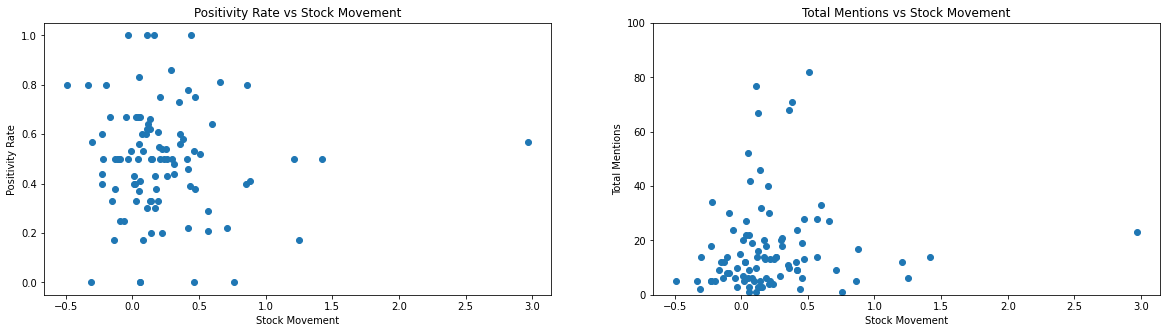

In [327]:
print('correlation: ', np.corrcoef(df_top_sent_comp['POS_%'], df_top_sent_comp['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent_comp)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent_comp)
ax2.set_ylim(bottom=0, top=100)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

In [76]:
industry = 'Industrials'
subindustry = 'Machinery'
country = 'United States'
df_top_sent_comp = df_comp[(df_comp['industry'] == industry) & (df_comp['subindustry'] == subindustry) & (df_comp['country'] == country) & df_comp['filtered_names_match'].isin(comp_select)]
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['topic_score'] > 0.5]
df_top_sent_comp = df_top_sent_comp.explode('topic_label').groupby(['filtered_names_match', 'topic_label', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp = df_top_sent_comp.fillna(0)
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
#df_top_sent_comp = df_top_sent_comp.sort_values(by='Total', ascending=False)
df_top_sent_comp[df_top_sent_comp['Total'] >= 10][:30]

NEGATIVE  POSITIVE  Total
filtered_names_match topic_label                                     
AAP, Inc.            case_numbers               11.0       4.0   15.0
                     covid                      40.0      13.0   53.0
                     india                      17.0       5.0   22.0
                     other                      12.0       3.0   15.0
                     remote_learning             8.0       2.0   10.0
                     schools                    13.0       4.0   17.0
                     us                          8.0       2.0   10.0
Caterpillar Inc.                                81.0      26.0  107.0
                     finance                   140.0      92.0  232.0
                     general_stock_updates      57.0      36.0   93.0
                     general_updates            12.0      14.0   26.0
                     result_announcements        3.0       8.0   11.0
                     technavio_updates           8.0      12.0   20.0
                     us_shares                  28.0      13.0   41.0
                     us_stock_updates            5.0       6.0   11.0
Deere & Company                                 15.0       4.0   19.0
                     covid                      24.0       5.0   29.0
                     finance                    28.0      29.0   57.0
                     general_stock_updates       3.0      11.0   14.0
                     us                         14.0       2.0   16.0
SPX Corporation                                139.0      74.0  213.0
                     ad_revenue                  7.0       9.0   16.0
                     airlines                   25.0       4.0   29.0
                     amd                        16.0      20.0   36.0
                     asian_shares               27.0      18.0   45.0
                     bankruptcy                 11.0       1.0   12.0
                     bonds                      18.0       3.0   21.0
                     cannabis_companies          7.0       4.0   11.0
                     china                       8.0       4.0   12.0
                     clothing_retailers         33.0      22.0   55.0

### Airlines

In [328]:
industry = 'Industrials'
subindustry = 'Airlines'
country = 'United States'
df_top_sent_comp = df_comp[(df_comp['industry'] == industry) & (df_comp['subindustry'] == subindustry) & (df_comp['country'] == country)]
df_top_sent_comp = df_top_sent_comp.groupby(['filtered_names_match', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp = df_top_sent_comp.fillna(0)
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
df_top_sent_comp = df_top_sent_comp.sort_values(by='Total', ascending=False)
comp_select = df_top_sent_comp.index[:5]
df_top_sent_comp['POS_%'] = round(df_top_sent_comp['POSITIVE'] / df_top_sent_comp['Total'],2)
df_top_sent_comp['ticker'] =  df_top_sent_comp.index.map(comp_ticker_dict)
df_top_sent_comp['stock_mvmt'] = df_top_sent_comp['ticker'].map(stock_final_mvmt_dict)
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['stock_mvmt'].notna()]
df_top_sent_comp[df_top_sent_comp['Total'] >= 10].sort_values(by="POS_%", ascending=False)[:20]

,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
"SkyWest, Inc.",16.0,16.0,32.0,0.50,SKYW,-0.29
"Mesa Air Group, Inc.",5.0,5.0,10.0,0.50,MESA,-0.24
"Alaska Air Group, Inc.",92.0,78.0,170.0,0.46,ALK,-0.24
Allegiant Travel Company,39.0,23.0,62.0,0.37,ALGT,0.09
"Hawaiian Holdings, Inc.",27.0,15.0,42.0,0.36,HA,-0.30
JetBlue Airways Corporation,263.0,122.0,385.0,0.32,JBLU,-0.28
"Spirit Airlines, Inc.",94.0,42.0,136.0,0.31,SAVE,-0.37
American Airlines Group Inc.,1782.0,764.0,2546.0,0.30,AAL,-0.36
"Delta Air Lines, Inc.",887.0,355.0,1242.0,0.29,DAL,-0.31


0.27209874407715984


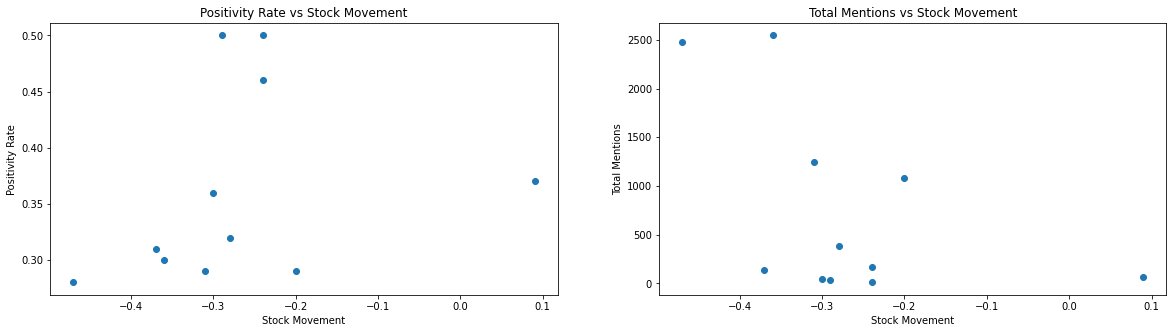

In [329]:
print(np.corrcoef(df_top_sent_comp['POS_%'], df_top_sent_comp['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent_comp)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent_comp)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

In [58]:
industry = 'Industrials'
subindustry = 'Airlines'
country = 'United States'
df_top_sent_comp = df_comp[(df_comp['industry'] == industry) & (df_comp['subindustry'] == subindustry) & (df_comp['country'] == country) & df_comp['filtered_names_match'].isin(comp_select)]
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['topic_score'] > 0.5]
df_top_sent_comp = df_top_sent_comp.explode('topic_label').groupby(['filtered_names_match', 'topic_label', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
#df_top_sent_comp = df_top_sent_comp.sort_values(by='Total', ascending=False)
df_top_sent_comp[df_top_sent_comp['Total'] >= 10][:30]

NEGATIVE  POSITIVE   Total
filtered_names_match         topic_label                                      
American Airlines Group Inc.                           208.0     114.0   322.0
                             airlines                  657.0     178.0   835.0
                             boeing                     65.0      30.0    95.0
                             case_numbers               16.0       5.0    21.0
                             cashay_updates              6.0       8.0    14.0
                             china                       9.0       2.0    11.0
                             company_specific           13.0       4.0    17.0
                             cost_cutting               64.0       9.0    73.0
                             covid                     214.0      50.0   264.0
                             covid_stimulus             11.0       2.0    13.0
                             finance                  1021.0     395.0  1416.0
                             flight_cuts                64.0       9.0    73.0
                             flights_suspended          52.0       6.0    58.0
                             ge_aviationboeing          10.0       3.0    13.0
                             general_stock_updates     109.0     104.0   213.0
                             general_updates             6.0       6.0    12.0
                             hotels                      5.0       6.0    11.0
                             nytimes_updates            35.0       2.0    37.0
                             other                      43.0       5.0    48.0
                             redundancies               26.0       5.0    31.0
                             robinhood_app               8.0       6.0    14.0
                             safety_measures            88.0      12.0   100.0
                             unemployment               31.0       5.0    36.0
                             us                         56.0      11.0    67.0
                             us_shares                  53.0      35.0    88.0
                             us_stock_updates           40.0      25.0    65.0
                             us_stocks_down             15.0       NaN    15.0
                             warren_buffett             31.0       7.0    38.0
Delta Air Lines, Inc.                                  110.0      60.0   170.0
                             airlines                  401.0      84.0   485.0

### Consumer Staples - Food Products

In [330]:
industry = 'Consumer Staples'
subindustry = 'Food Products'
country = 'United States'
df_top_sent_comp = df_comp[(df_comp['industry'] == industry) & (df_comp['subindustry'] == subindustry) & (df_comp['country'] == country)]
df_top_sent_comp = df_top_sent_comp.groupby(['filtered_names_match', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp = df_top_sent_comp.fillna(0)
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
df_top_sent_comp = df_top_sent_comp.sort_values(by='Total', ascending=False)
comp_select = df_top_sent_comp.index[:5]
df_top_sent_comp['POS_%'] = round(df_top_sent_comp['POSITIVE'] / df_top_sent_comp['Total'],2)
df_top_sent_comp['ticker'] =  df_top_sent_comp.index.map(comp_ticker_dict)
df_top_sent_comp['stock_mvmt'] = df_top_sent_comp['ticker'].map(stock_final_mvmt_dict)
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['stock_mvmt'].notna()]
df_top_sent_comp[df_top_sent_comp['Total'] >= 10].sort_values(by="POS_%", ascending=False)[:20]

,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
The Simply Good Foods Company,0.0,10.0,10.0,1.00,SMPL,0.24
"Calavo Growers, Inc.",2.0,8.0,10.0,0.80,CVGW,0.01
Landec Corporation,3.0,8.0,11.0,0.73,LNDC,-0.05
"The Hain Celestial Group, Inc.",12.0,28.0,40.0,0.70,HAIN,0.72
"B&G Foods, Inc.",13.0,31.0,44.0,0.70,BGS,1.57
"TreeHouse Foods, Inc.",6.0,11.0,17.0,0.65,THS,-0.05
"Conagra Brands, Inc.",13.0,24.0,37.0,0.65,CAG,0.08
"Cal-Maine Foods, Inc.",8.0,14.0,22.0,0.64,CALM,0.07
"Flowers Foods, Inc.",7.0,11.0,18.0,0.61,FLO,0.10


0.2162431082912166


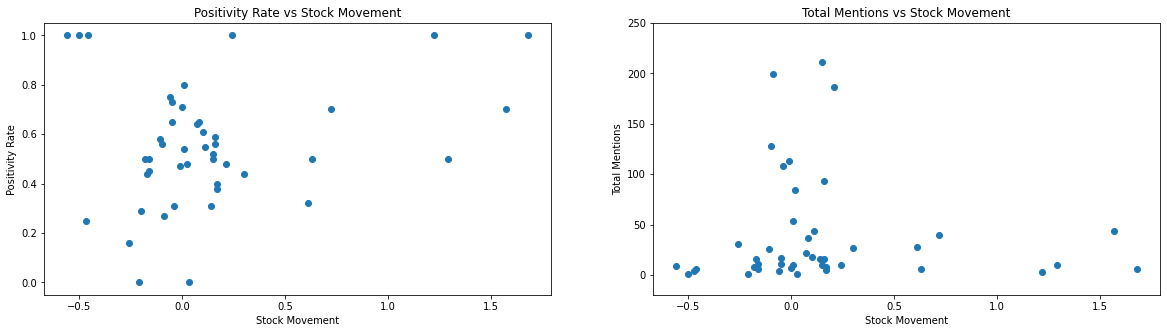

In [331]:
print(np.corrcoef(df_top_sent_comp['POS_%'], df_top_sent_comp['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent_comp)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent_comp)
ax2.set_ylim(top=250)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

### Consumer Staples - Food Products - Australia

In [332]:
industry = 'Consumer Staples'
subindustry = 'Food Products'
country = 'Australia'
df_top_sent_comp = df_comp[(df_comp['industry'] == industry) & (df_comp['country'] == country)]
df_top_sent_comp = df_top_sent_comp.groupby(['filtered_names_match', 'sentiment']).count()[['date']].sort_values(by='date', ascending=False)
df_top_sent_comp = df_top_sent_comp.unstack()#.reset_index()
df_top_sent_comp = df_top_sent_comp.fillna(0)
df_top_sent_comp.columns = df_top_sent_comp.columns.droplevel()
df_top_sent_comp.rename_axis(None, inplace=True, axis=1)
df_top_sent_comp['Total'] = df_top_sent_comp.sum(axis=1)
df_top_sent_comp = df_top_sent_comp.sort_values(by='Total', ascending=False)
comp_select = df_top_sent_comp.index[:5]
df_top_sent_comp['POS_%'] = round(df_top_sent_comp['POSITIVE'] / df_top_sent_comp['Total'],2)
df_top_sent_comp['ticker'] =  df_top_sent_comp.index.map(comp_ticker_dict)
df_top_sent_comp['stock_mvmt'] = df_top_sent_comp['ticker'].map(stock_final_mvmt_au_dict)
df_top_sent_comp = df_top_sent_comp[df_top_sent_comp['stock_mvmt'].notna()]
df_top_sent_comp#[df_top_sent_comp['Total'] >= 10].sort_values(by="POS_%", ascending=False)[:20]

,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
Woolworths Group Limited,7.0,12.0,19.0,0.63,WOW,0.00
Elders Limited,4.0,10.0,14.0,0.71,ELD,0.46
Coles Group Limited,7.0,6.0,13.0,0.46,COL,0.14
Costa Group Holdings Limited,6.0,3.0,9.0,0.33,CGC,0.45
Inghams Group Limited,1.0,1.0,2.0,0.50,ING,-0.03
Australian Agricultural Company Limited,2.0,0.0,2.0,0.00,AAC,-0.01
Freedom Foods Group Limited,1.0,1.0,2.0,0.50,FNP,-0.37
GrainCorp Limited,0.0,1.0,1.0,1.00,GNC,-0.51
Clean Seas Seafood Limited,0.0,1.0,1.0,1.00,CSS,0.13


-0.36775133860308384


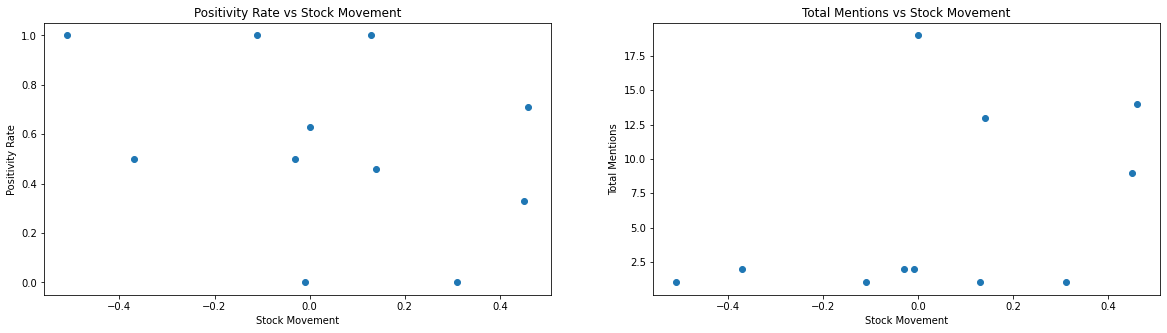

In [333]:
print(np.corrcoef(df_top_sent_comp['POS_%'], df_top_sent_comp['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent_comp)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent_comp)
#ax2.set_ylim(top=250)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

# By Company

In [78]:
df_comp.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,distilbert,finbert,roberta,sentiment_match,sentiment,topic_id,topic_label,topic_label_str,topic_score,topic_words,primary_topic,filtered_names_match,nb_companies,blockchain,digitization,machine_learne,cloud,iot,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification,nb_comp_0,industry,subindustry,ticker_symbol,country
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,POSITIVE,NEUTRAL,POSITIVE,False,POSITIVE,970,,,0.437342,"[caterpillar, ibe, fourthquarter, secondquarte...",,Caterpillar Inc.,5,0.64344,0.492892,0.579234,0.571812,0.521615,0.453935,0.221586,0.588197,0.209348,0.51657,0.274569,0.142759,0.503211,0.464359,0.674917,0,Industrials,Machinery,CAT,United States


In [310]:
df_comp_month = df_comp.copy()
df_comp_month['month'] = df_comp_month['date'].dt.month

In [322]:
company_analysis = 'NVIDIA Corporation'
df_comp_analysis = df_comp_month[df_comp_month['filtered_names_match'] == company_analysis]
df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='sentiment', values='date', aggfunc='count', fill_value=0)
df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)

ticker = comp_ticker_dict[company_analysis]
stock_mvmt_analysis = stock_final.loc[ticker].pct_change()[1:13]
stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

df_comp_analysis['stock_mvmt'] = stock_mvmt_analysis
df_comp_analysis = df_comp_analysis.reset_index()
df_comp_analysis

sentiment,month,NEGATIVE,POSITIVE,Total,POS_%,stock_mvmt
0,1,1,0,1,0.00,0.142283
1,2,47,23,70,0.33,-0.023373
2,3,16,11,27,0.41,0.108801
3,4,16,7,23,0.30,0.214657
4,5,31,32,63,0.51,0.070109
5,6,34,47,81,0.58,0.118117
6,7,28,43,71,0.61,0.259992
7,8,20,38,58,0.66,0.011664
8,9,41,70,111,0.63,-0.073371
9,10,6,8,14,0.57,0.069212


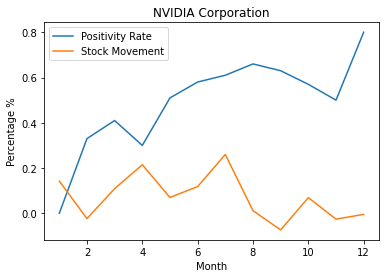

In [323]:
plt.plot('month', 'POS_%', data=df_comp_analysis, label='Positivity Rate')
plt.plot('month', 'stock_mvmt', data=df_comp_analysis, label='Stock Movement')
plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.legend()
plt.title(company_analysis)
plt.show()

In [324]:
company_analysis = 'American Airlines Group Inc.'
df_comp_analysis = df_comp_month[df_comp_month['filtered_names_match'] == company_analysis]
df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='sentiment', values='date', aggfunc='count')
df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)

ticker = comp_ticker_dict[company_analysis]
stock_mvmt_analysis = stock_final.loc[ticker].pct_change()[1:13]
stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

df_comp_analysis['stock_mvmt'] = stock_mvmt_analysis
df_comp_analysis = df_comp_analysis.reset_index()
df_comp_analysis

sentiment,month,NEGATIVE,POSITIVE,Total,POS_%,stock_mvmt
0,1,85,7,92,0.08,-0.290239
1,2,93,11,104,0.11,-0.357740
2,3,253,56,309,0.18,-0.014766
3,4,135,54,189,0.29,-0.125729
4,5,154,89,243,0.37,0.244762
5,6,309,196,505,0.39,-0.149197
6,7,355,122,477,0.26,0.173561
7,8,77,38,115,0.33,-0.058238
8,9,117,55,172,0.32,-0.082181
9,10,71,30,101,0.30,0.252660


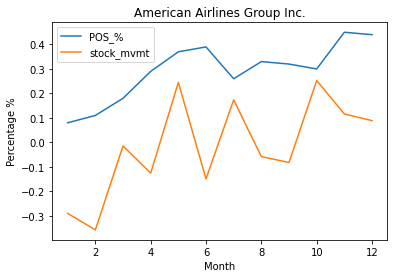

In [325]:
plt.plot('month', 'POS_%', data=df_comp_analysis)
plt.plot('month', 'stock_mvmt', data=df_comp_analysis)
plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.legend()
plt.title(company_analysis)
plt.show()

# By Company - Company Relevance

In [78]:
df_comp.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,distilbert,finbert,roberta,sentiment_match,sentiment,topic_id,topic_label,topic_label_str,topic_score,topic_words,primary_topic,filtered_names_match,nb_companies,blockchain,digitization,machine_learne,cloud,iot,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification,nb_comp_0,industry,subindustry,ticker_symbol,country
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,POSITIVE,NEUTRAL,POSITIVE,False,POSITIVE,970,,,0.437342,"[caterpillar, ibe, fourthquarter, secondquarte...",,Caterpillar Inc.,5,0.64344,0.492892,0.579234,0.571812,0.521615,0.453935,0.221586,0.588197,0.209348,0.51657,0.274569,0.142759,0.503211,0.464359,0.674917,0,Industrials,Machinery,CAT,United States


sentiment,month,NEGATIVE,POSITIVE,Total,POS_%,stock_mvmt
0,2,35,16,51,0.31,-0.023373
1,3,10,10,20,0.50,0.108801
2,4,8,5,13,0.38,0.214657
3,5,23,25,48,0.52,0.070109
4,6,17,24,41,0.59,0.118117
5,7,12,26,38,0.68,0.259992
6,8,14,23,37,0.62,0.011664
7,9,24,50,74,0.68,-0.073371
8,10,2,5,7,0.71,0.069212
9,11,7,3,10,0.30,-0.025855


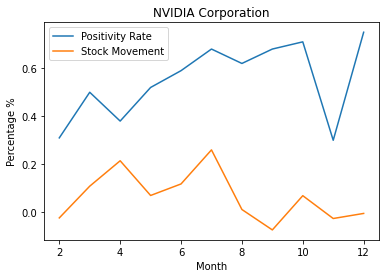

In [119]:
df_comp_month = df_comp[df_comp['company_relevance'] >= 0.2].copy()
df_comp_month['month'] = df_comp_month['date'].dt.month

company_analysis = 'NVIDIA Corporation'
df_comp_analysis = df_comp_month[df_comp_month['filtered_names_match'] == company_analysis]
df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='sentiment', values='date', aggfunc='count', fill_value=0)
df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)

ticker = comp_ticker_dict[company_analysis]
stock_mvmt_analysis = stock_final.loc[ticker].pct_change()[1:13]
stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

df_comp_analysis['stock_mvmt'] = stock_mvmt_analysis
df_comp_analysis = df_comp_analysis.reset_index()
display(df_comp_analysis)

plt.plot('month', 'POS_%', data=df_comp_analysis, label='Positivity Rate')
plt.plot('month', 'stock_mvmt', data=df_comp_analysis, label='Stock Movement')
plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.legend()
plt.title(company_analysis)
plt.show()

sentiment,month,NEGATIVE,POSITIVE,Total,POS_%,stock_mvmt
0,1,49,7,56,0.12,-0.290239
1,2,48,7,55,0.13,-0.357740
2,3,157,31,188,0.16,-0.014766
3,4,71,20,91,0.22,-0.125729
4,5,88,44,132,0.33,0.244762
5,6,177,101,278,0.36,-0.149197
6,7,230,63,293,0.22,0.173561
7,8,62,25,87,0.29,-0.058238
8,9,101,36,137,0.26,-0.082181
9,10,52,17,69,0.25,0.252660


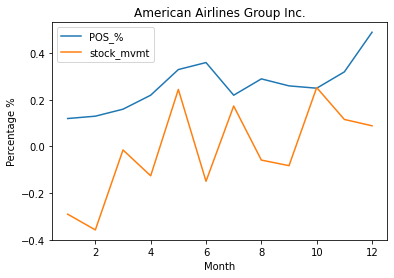

In [118]:
df_comp_month = df_comp[df_comp['company_relevance'] >= 0.2].copy()
df_comp_month['month'] = df_comp_month['date'].dt.month

company_analysis = 'American Airlines Group Inc.'
df_comp_analysis = df_comp_month[df_comp_month['filtered_names_match'] == company_analysis]
df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='sentiment', values='date', aggfunc='count')
df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)

ticker = comp_ticker_dict[company_analysis]
stock_mvmt_analysis = stock_final.loc[ticker].pct_change()[1:13]
stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

df_comp_analysis['stock_mvmt'] = stock_mvmt_analysis
df_comp_analysis = df_comp_analysis.reset_index()
display(df_comp_analysis)

plt.plot('month', 'POS_%', data=df_comp_analysis)
plt.plot('month', 'stock_mvmt', data=df_comp_analysis)
plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.legend()
plt.title(company_analysis)
plt.show()

sentiment,month,NEGATIVE,POSITIVE,Total,POS_%,stock_mvmt
0,1,0,1,1,1.00,-0.052810
1,2,6,0,6,0.00,-0.022847
2,3,14,2,16,0.12,0.096007
3,4,17,10,27,0.37,0.019925
4,5,12,13,25,0.52,0.027897
5,6,39,24,63,0.38,0.003257
6,7,18,61,79,0.77,0.036283
7,8,20,39,59,0.66,0.043342
8,9,59,57,116,0.49,-0.060134
9,10,3,1,4,0.25,0.032859


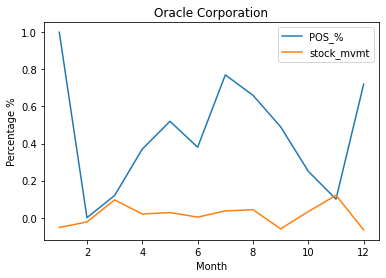

In [121]:
df_comp_month = df_comp[df_comp['company_relevance'] >= 0.2].copy()
df_comp_month['month'] = df_comp_month['date'].dt.month

company_analysis = 'Oracle Corporation'
df_comp_analysis = df_comp_month[df_comp_month['filtered_names_match'] == company_analysis]
df_comp_analysis = df_comp_analysis.pivot_table(index='month', columns='sentiment', values='date', aggfunc='count', fill_value=0)
df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)

ticker = comp_ticker_dict[company_analysis]
stock_mvmt_analysis = stock_final.loc[ticker].pct_change()[1:13]
stock_mvmt_analysis.index = [1,2,3,4,5,6,7,8,9,10,11,12]

df_comp_analysis['stock_mvmt'] = stock_mvmt_analysis
df_comp_analysis = df_comp_analysis.reset_index()
display(df_comp_analysis)

plt.plot('month', 'POS_%', data=df_comp_analysis)
plt.plot('month', 'stock_mvmt', data=df_comp_analysis)
plt.xlabel("Month")
plt.ylabel("Percentage %")
plt.legend()
plt.title(company_analysis)
plt.show()

# By Industry

In [133]:
exclude_marketscreener = True

if exclude_marketscreener:
    df_comp_analysis = df_comp_month[df_comp_month['domain'] != "marketscreener"].copy()
else:
    df_comp_analysis = df_comp_month.copy()
df_comp_analysis = df_comp_analysis.pivot_table(index=['industry', 'month'], columns='sentiment', values='date', aggfunc='count')
df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)

stock_log_ind_mvmt = stock_log_ind.T.pct_change()
stock_log_ind_mvmt = stock_log_ind_mvmt.dropna()
stock_log_ind_mvmt.index = [1,2,3,4,5,6,7,8,9,10,11,12]
stock_log_ind_mvmt = pd.DataFrame(stock_log_ind_mvmt.stack()).reset_index()
stock_log_ind_mvmt.columns = ['month', 'industry', 'stock_mvmt']

df_comp_analysis = df_comp_analysis.merge(stock_log_ind_mvmt, left_on=['industry', 'month'], right_on=['industry', 'month'])
df_comp_analysis

,industry,month,NEGATIVE,POSITIVE,Total,POS_%,stock_mvmt
0,Consumer Discreptionary,1,441,99,540,0.18,-0.035931
1,Consumer Discreptionary,2,1265,367,1632,0.22,-0.141726
2,Consumer Discreptionary,3,4427,1178,5605,0.21,0.076037
3,Consumer Discreptionary,4,3882,1542,5424,0.28,0.033905
4,Consumer Discreptionary,5,4465,2151,6616,0.33,0.018258
...,...,...,...,...,...,...,...
127,Utilities,8,145,106,251,0.42,-0.006921
128,Utilities,9,122,77,199,0.39,0.008454
129,Utilities,10,45,29,74,0.39,0.020664
130,Utilities,11,65,63,128,0.49,0.006368


In [134]:
df_comp_analysis['industry'].unique()

array(['Consumer Discreptionary', 'Consumer Staples', 'Energy',
       'Financials', 'Healthcare', 'Industrials',
       'Information Technology', 'Materials', 'Real Estate',
       'Telecommunication Services', 'Utilities'], dtype=object)

0.34389600379526064
-0.00214711575189068
0.24516100004388405
0.3839533686359445
0.15982506145719277
0.390930548890713
0.24877735336146872
0.4163971228792039
0.081760959807595
0.29088442883389204
0.45980421612025346


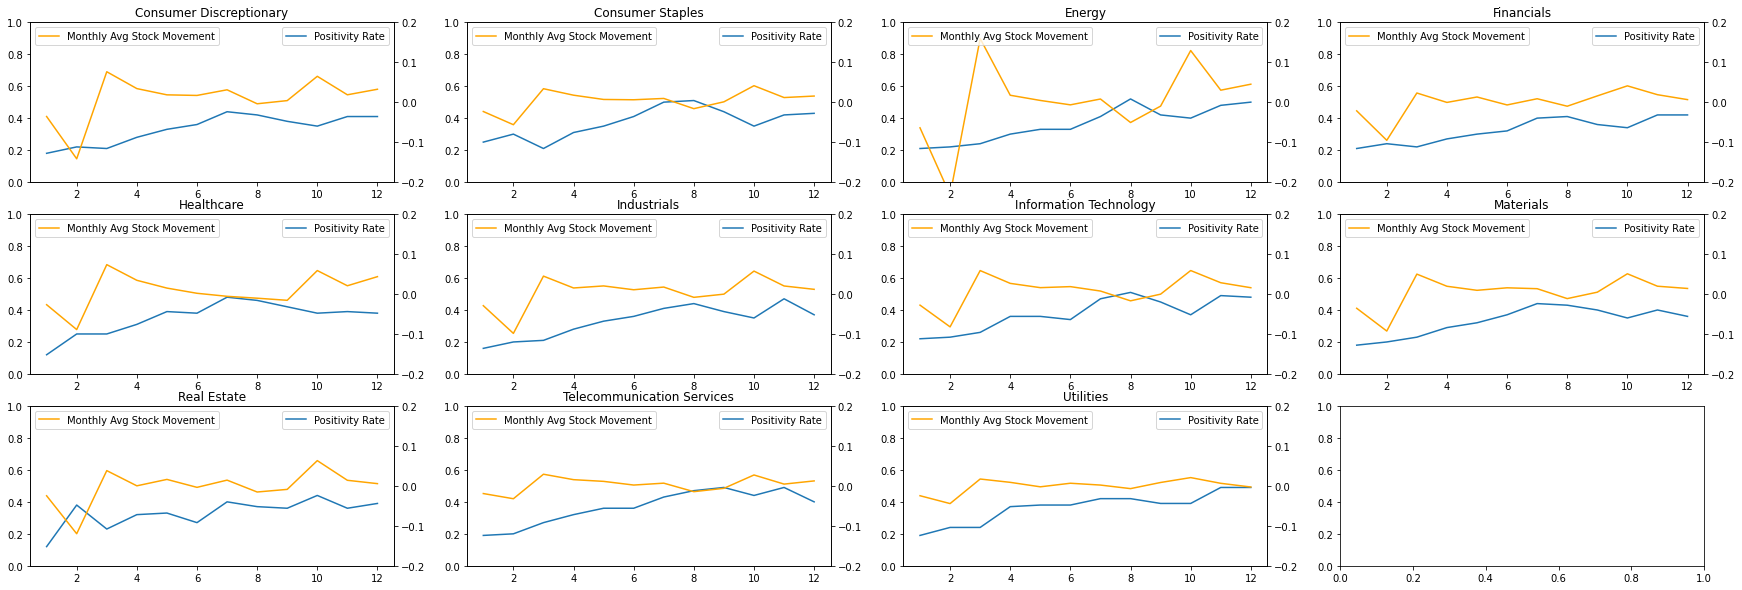

In [135]:
fig, ax = plt.subplots(3,4, figsize=(30,10), sharey=False)
ax = ax.flatten()

for idx, industry in enumerate(df_comp_analysis['industry'].unique()):
    ax[idx].plot('month', 'POS_%', data=df_comp_analysis[df_comp_analysis['industry'] == industry], label="Positivity Rate")
    ax2 = ax[idx].twinx()
    ax2.plot('month', 'stock_mvmt', data=df_comp_analysis[df_comp_analysis['industry'] == industry], label="Monthly Avg Stock Movement", color="orange")
    ax[idx].set_title(industry)
    ax[idx].legend()
    ax[idx].set_ylim(0,1)
    ax2.set_ylim(-0.2,0.2)
    ax2.legend(loc="upper left")
    print(np.corrcoef(df_comp_analysis[df_comp_analysis['industry'] == industry]['POS_%'], df_comp_analysis[df_comp_analysis['industry'] == industry]['stock_mvmt']).flatten()[1])

# By Industry - Company Relevance

In [112]:
#df_comp_month = df_comp.copy()
df_comp_month = df_comp[df_comp['company_relevance'] >= 0.2].copy()
df_comp_month['month'] = df_comp_month['date'].dt.month

exclude_marketscreener = True

if exclude_marketscreener:
    df_comp_analysis = df_comp_month[df_comp_month['domain'] != "marketscreener"].copy()
else:
    df_comp_analysis = df_comp_month.copy()
df_comp_analysis = df_comp_analysis.pivot_table(index=['industry', 'month'], columns='sentiment', values='date', aggfunc='count')
df_comp_analysis['Total'] = df_comp_analysis.sum(axis=1)
df_comp_analysis['POS_%'] = round(df_comp_analysis['POSITIVE'] / df_comp_analysis['Total'],2)

stock_log_ind_mvmt = stock_log_ind.T.pct_change()
stock_log_ind_mvmt = stock_log_ind_mvmt.dropna()
stock_log_ind_mvmt.index = [1,2,3,4,5,6,7,8,9,10,11,12]
stock_log_ind_mvmt = pd.DataFrame(stock_log_ind_mvmt.stack()).reset_index()
stock_log_ind_mvmt.columns = ['month', 'industry', 'stock_mvmt']

df_comp_analysis = df_comp_analysis.merge(stock_log_ind_mvmt, left_on=['industry', 'month'], right_on=['industry', 'month'])
df_comp_analysis

,industry,month,NEGATIVE,POSITIVE,Total,POS_%,stock_mvmt
0,Consumer Discreptionary,1,235,60,295,0.20,-0.035931
1,Consumer Discreptionary,2,904,227,1131,0.20,-0.141726
2,Consumer Discreptionary,3,3599,888,4487,0.20,0.076037
3,Consumer Discreptionary,4,3233,1215,4448,0.27,0.033905
4,Consumer Discreptionary,5,3657,1686,5343,0.32,0.018258
...,...,...,...,...,...,...,...
127,Utilities,8,135,93,228,0.41,-0.006921
128,Utilities,9,107,74,181,0.41,0.008454
129,Utilities,10,41,26,67,0.39,0.020664
130,Utilities,11,58,49,107,0.46,0.006368


In [113]:
df_comp_analysis['industry'].unique()

array(['Consumer Discreptionary', 'Consumer Staples', 'Energy',
       'Financials', 'Healthcare', 'Industrials',
       'Information Technology', 'Materials', 'Real Estate',
       'Telecommunication Services', 'Utilities'], dtype=object)

0.36781260603385263
-0.10755493796066026
0.1728792880717525
0.3741487534086827
0.1424384537465288
0.360150345421993
0.2942546967320021
0.4213731902819139
0.4711074164727741
0.2775216328335903
0.4600112026528761


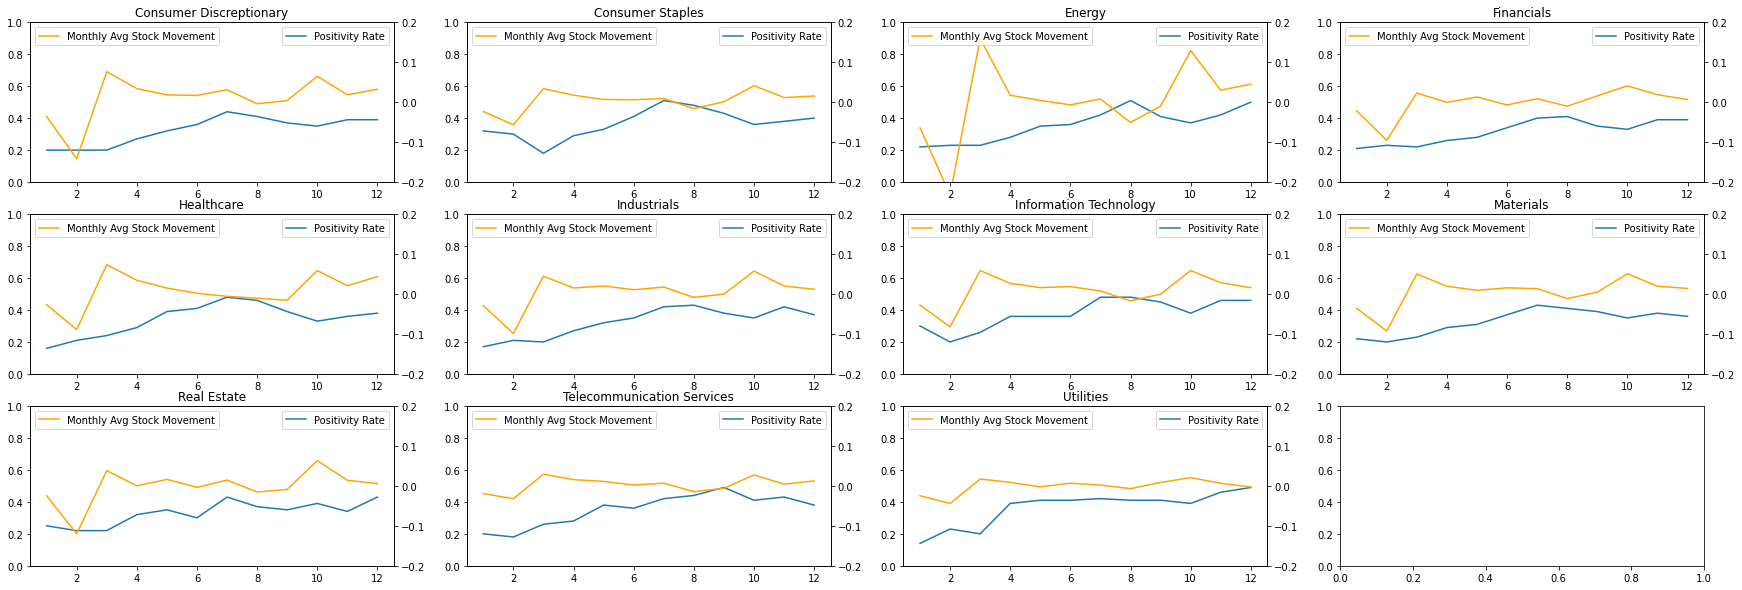

In [114]:
fig, ax = plt.subplots(3,4, figsize=(30,10), sharey=False)
ax = ax.flatten()

for idx, industry in enumerate(df_comp_analysis['industry'].unique()):
    ax[idx].plot('month', 'POS_%', data=df_comp_analysis[df_comp_analysis['industry'] == industry], label="Positivity Rate")
    ax2 = ax[idx].twinx()
    ax2.plot('month', 'stock_mvmt', data=df_comp_analysis[df_comp_analysis['industry'] == industry], label="Monthly Avg Stock Movement", color="orange")
    ax[idx].set_title(industry)
    ax[idx].legend()
    ax[idx].set_ylim(0,1)
    ax2.set_ylim(-0.2,0.2)
    ax2.legend(loc="upper left")
    print(np.corrcoef(df_comp_analysis[df_comp_analysis['industry'] == industry]['POS_%'], df_comp_analysis[df_comp_analysis['industry'] == industry]['stock_mvmt']).flatten()[1])

# Potential Areas
- Supply chain
- Digitisation
- Product Developments
- Employee Pay


In [226]:
df_topics.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,topic_id,topic_label,topic_score,topic_score_rating,topic_words,primary_topic,secondary_topics,topic_label_str
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,970,,0.437342,low,"[caterpillar, ibe, fourthquarter, secondquarte...",,,


# Specific Topic Words Mentioned in an Article

In [337]:
keyword = 'supply_chain'
df_kw = df_combined[df_combined['topic_words'].apply(lambda x: keyword in x)]
df_kw = df_kw.explode('filtered_names_match')
df_kw_financials = df_kw.pivot_table(index='filtered_names_match', columns='sentiment', values='date', aggfunc='count', fill_value=0)
df_kw_financials['Total'] = df_kw_financials.sum(axis=1)
df_kw_financials['POS_%'] = round(df_kw_financials['POSITIVE'] / df_kw_financials['Total'],2)

df_kw_financials = df_kw_financials.reset_index()
df_kw_financials['ticker'] = df_kw_financials['filtered_names_match'].map(comp_ticker_dict)
df_kw_financials['stock_mvmt'] = df_kw_financials['ticker'].map(stock_final_mvmt_dict)
df_kw_financials = df_kw_financials[df_kw_financials['stock_mvmt'].notna()]
df_kw_financials = df_kw_financials[df_kw_financials['Total'] > 5]
df_kw_financials[:10]

sentiment,filtered_names_match,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
0,3D Resources Limited,0,6,6,1.00,DDD,2.26
1,3M Company,7,2,9,0.22,MMM,0.15
18,"Advanced Micro Devices, Inc.",3,3,6,0.50,AMD,0.82
27,American Airlines Group Inc.,7,1,8,0.12,AAL,-0.36
40,Apple Inc.,142,37,179,0.21,AAPL,0.72
58,Ball Corporation,9,21,30,0.70,BLL,0.23
59,Bank of America Corporation,13,1,14,0.07,BAC,-0.07
68,"BlackRock, Inc.",2,4,6,0.67,BLK,0.36
112,Citigroup Inc.,4,2,6,0.33,C,-0.19
161,Ford Motor Company,2,5,7,0.71,F,0.21


0.30325060520471914


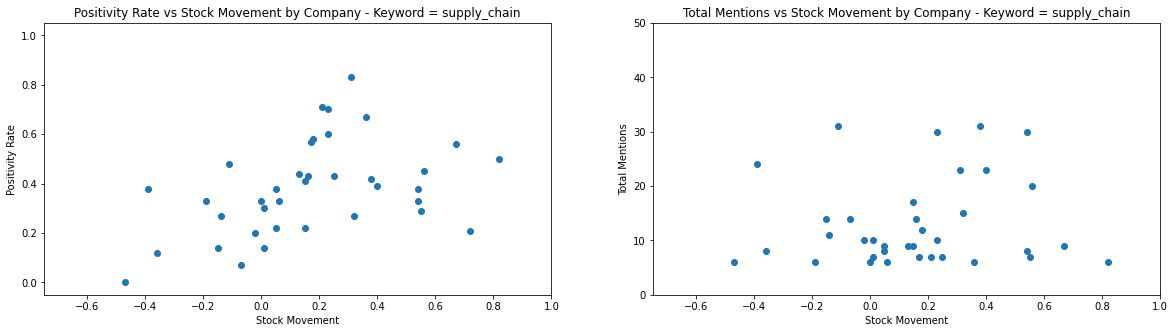

In [344]:
print(np.corrcoef(df_kw_financials['POS_%'], df_kw_financials['stock_mvmt']).flatten()[1])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_kw_financials)
ax2.scatter(x="stock_mvmt", y="Total", data=df_kw_financials)
ax2.set_ylim(bottom=0, top=50)
ax1.set_xlim(right=1)
ax2.set_xlim(right=1)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title(label=("Positivity Rate vs Stock Movement by Company - Keyword = " + keyword))
ax2.set_title(label=("Total Mentions vs Stock Movement by Company - Keyword = " + keyword))
plt.show()

In [346]:
keyword = 'digitization'
df_kw = df_combined[df_combined['topic_words'].apply(lambda x: keyword in x)]
df_kw = df_kw.explode('filtered_names_match')
df_kw_financials = df_kw.pivot_table(index='filtered_names_match', columns='sentiment', values='date', aggfunc='count', fill_value=0)
df_kw_financials['Total'] = df_kw_financials.sum(axis=1)
df_kw_financials['POS_%'] = round(df_kw_financials['POSITIVE'] / df_kw_financials['Total'],2)

df_kw_financials = df_kw_financials.reset_index()
df_kw_financials['ticker'] = df_kw_financials['filtered_names_match'].map(comp_ticker_dict)
df_kw_financials['stock_mvmt'] = df_kw_financials['ticker'].map(stock_final_mvmt_dict)
df_kw_financials = df_kw_financials[df_kw_financials['stock_mvmt'].notna()]
df_kw_financials = df_kw_financials[df_kw_financials['Total'] > 5]
df_kw_financials[:10]

sentiment,filtered_names_match,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
2,3D Resources Limited,16,38,54,0.70,DDD,2.26
11,"ACI Worldwide, Inc.",9,20,29,0.69,ACIW,0.11
13,AECOM,2,12,14,0.86,ACM,0.04
22,AMP Limited,1,11,12,0.92,AMP,0.23
24,"ANI Pharmaceuticals, Inc.",1,5,6,0.83,ANIP,-0.54
35,AT&T Inc.,6,8,14,0.57,T,-0.19
46,Adobe Inc.,7,18,25,0.72,ADBE,0.31
72,"Amazon.com, Inc.",3,10,13,0.77,AMZN,0.60
73,Amdocs Limited,3,4,7,0.57,DOX,0.00
74,American Airlines Group Inc.,4,3,7,0.43,AAL,-0.36


0.053395633776234866


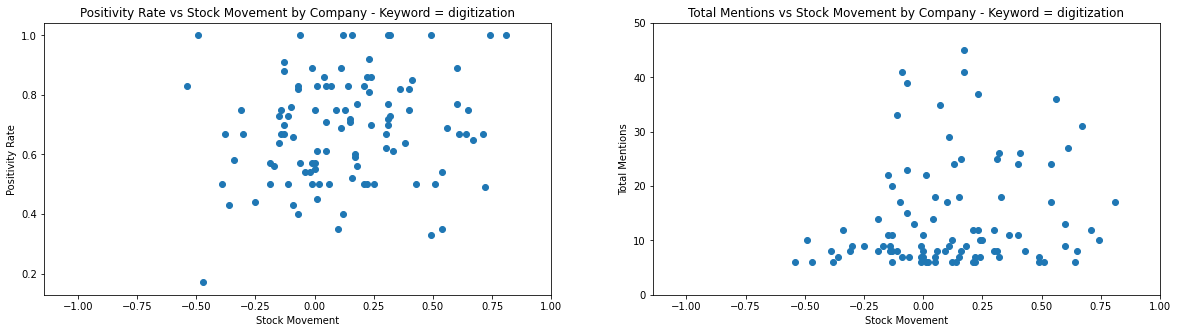

In [347]:
print(np.corrcoef(df_kw_financials['POS_%'], df_kw_financials['stock_mvmt']).flatten()[1])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_kw_financials)
ax2.scatter(x="stock_mvmt", y="Total", data=df_kw_financials)
ax2.set_ylim(bottom=0, top=50)
ax1.set_xlim(right=1)
ax2.set_xlim(right=1)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title(label=("Positivity Rate vs Stock Movement by Company - Keyword = " + keyword))
ax2.set_title(label=("Total Mentions vs Stock Movement by Company - Keyword = " + keyword))
plt.show()

# Domain - 

In [227]:
df_combined['domain'].value_counts()

finance.yahoo      91304
marketscreener     77255
express            44938
reuters            23856
cnbc               20962
                   ...  
instyle               34
altassets             22
emerj                 20
just-auto              9
businessinsider        3
Name: domain, Length: 66, dtype: int64

<AxesSubplot:xlabel='domain'>

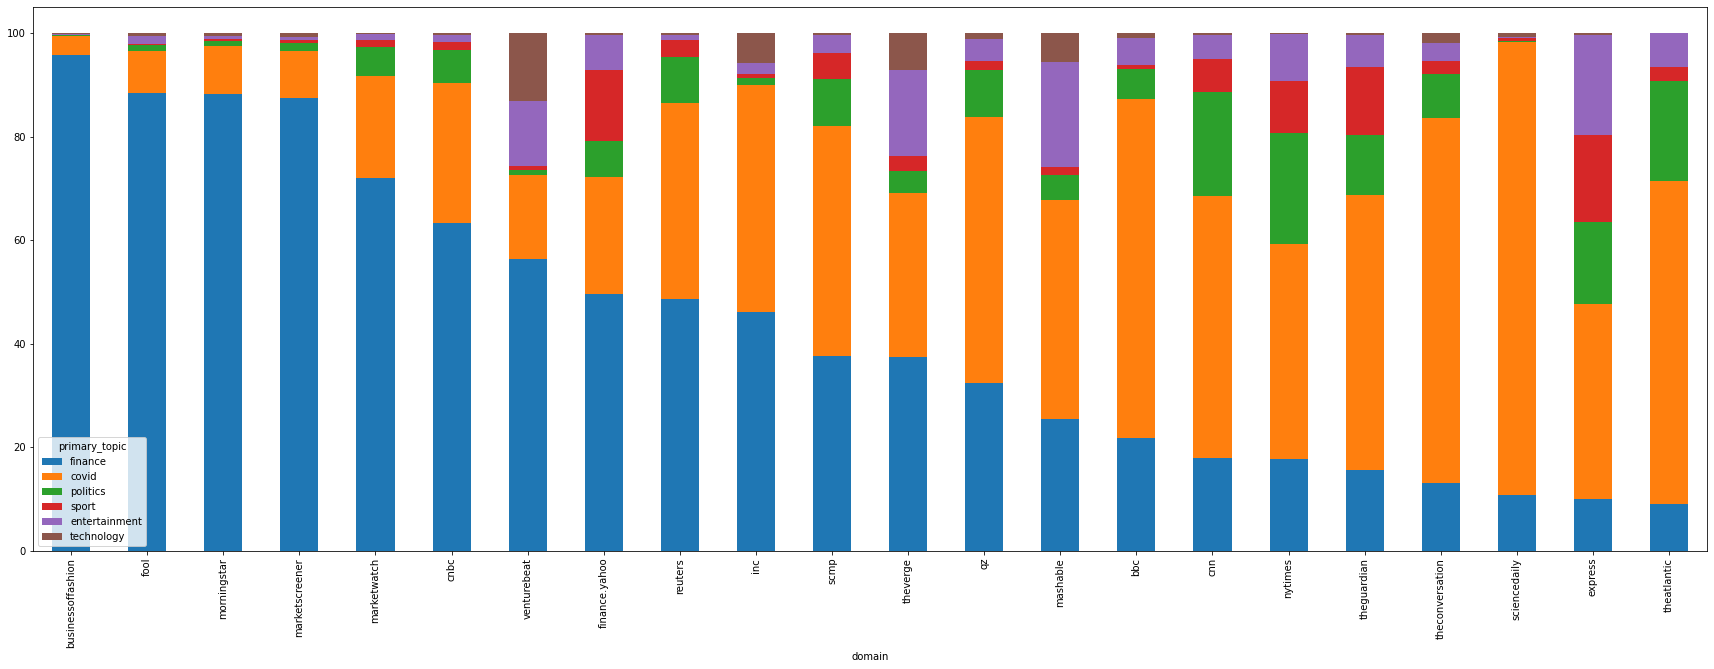

In [283]:
df_domain_chart = df_combined.pivot_table(index=['domain'], columns=['primary_topic'], values='date', aggfunc='count', fill_value=0)
num_articles_mask = df_domain_chart.sum(axis=1) > 1000
df_domain_chart = df_domain_chart[num_articles_mask]
df_domain_chart = df_domain_chart[['finance', 'covid', 'politics', 'sport', 'entertainment', 'technology']]
df_domain_chart = df_domain_chart.div(df_domain_chart.sum(axis=1), axis=0).multiply(100)
df_domain_chart = df_domain_chart.sort_values(by="finance", ascending=False)
df_domain_chart
df_domain_chart.plot.bar(stacked=True, figsize = (30,10))

<AxesSubplot:xlabel='domain'>

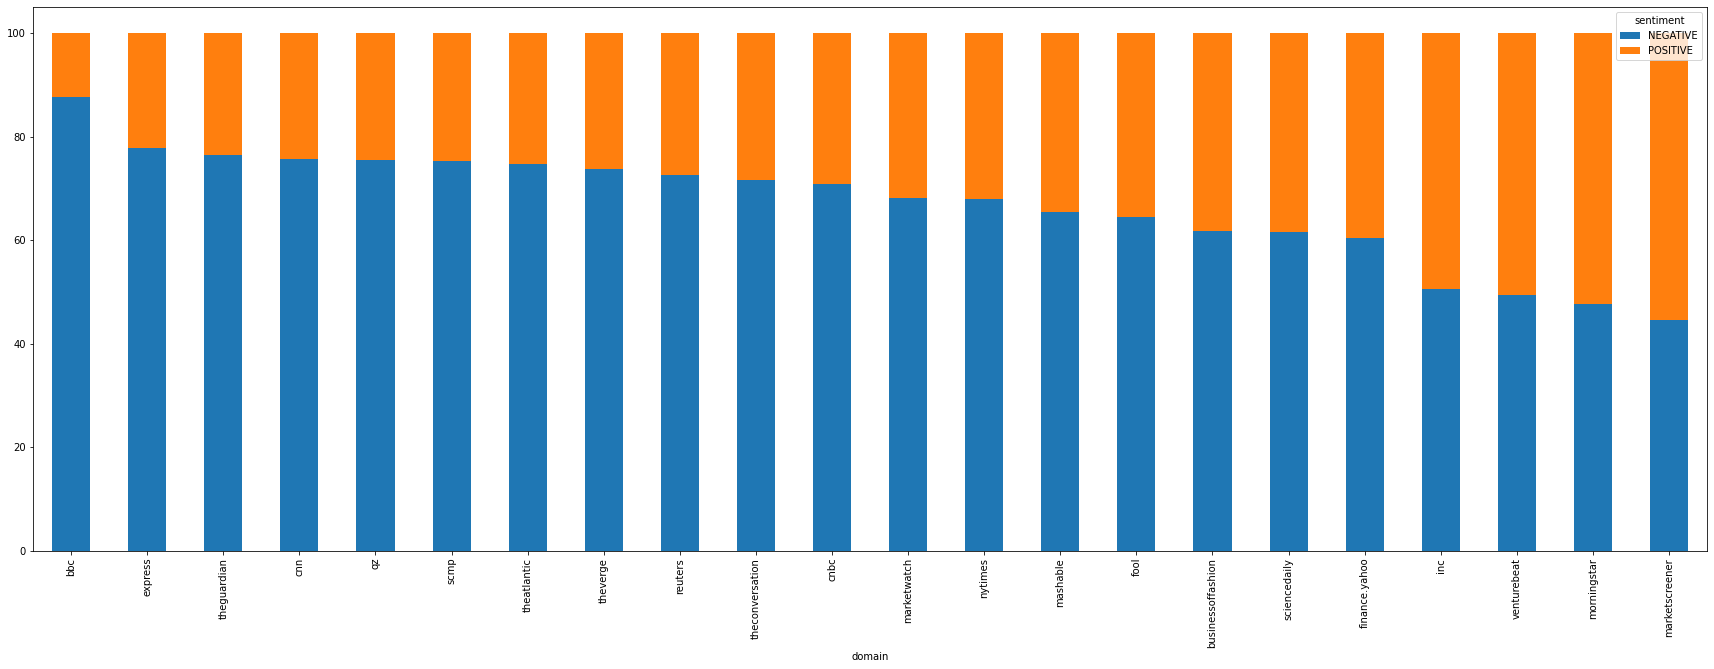

In [285]:
df_domain_chart = df_combined[df_combined['primary_topic'] == 'finance']
df_domain_chart = df_combined.pivot_table(index=['domain'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
num_articles_mask = df_domain_chart.sum(axis=1) > 1000
df_domain_chart = df_domain_chart[num_articles_mask]
df_domain_chart = df_domain_chart.div(df_domain_chart.sum(axis=1), axis=0).multiply(100)
df_domain_chart = df_domain_chart.sort_values(by="NEGATIVE", ascending=False)
df_domain_chart.plot.bar(stacked=True, figsize = (30,10))

# Countries

### Sentiment

<AxesSubplot:title={'center':'All Articles'}, xlabel='country'>

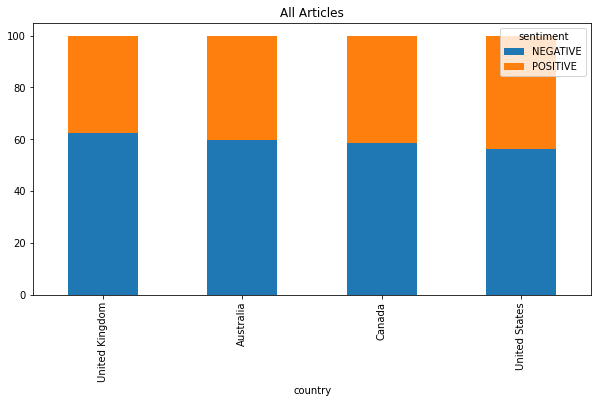

In [348]:
# All topics
df_comp_chart = df_comp.pivot_table(index="country", columns="sentiment", values="date", aggfunc='count', fill_value=0)
df_comp_chart = df_comp_chart.div(df_comp_chart.sum(axis=1), axis=0).multiply(100)
df_comp_chart = df_comp_chart.sort_values(by="NEGATIVE", ascending=False)
df_comp_chart.plot.bar(stacked=True, figsize = (10,5), title="All Articles")

<AxesSubplot:title={'center':'Finance Articles'}, xlabel='country'>

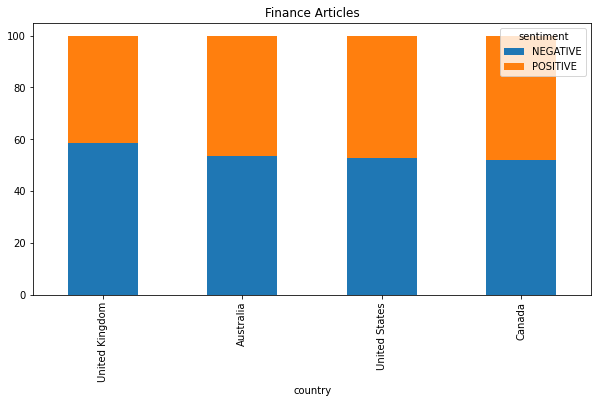

In [349]:
df_comp_chart = df_comp[df_comp['primary_topic'] == 'finance']
df_comp_chart = df_comp_chart.pivot_table(index="country", columns="sentiment", values="date", aggfunc='count', fill_value=0)
df_comp_chart = df_comp_chart.div(df_comp_chart.sum(axis=1), axis=0).multiply(100)
df_comp_chart = df_comp_chart.sort_values(by="NEGATIVE", ascending=False)
df_comp_chart.plot.bar(stacked=True, figsize = (10,5), title="Finance Articles")

### Topics

<AxesSubplot:xlabel='country'>

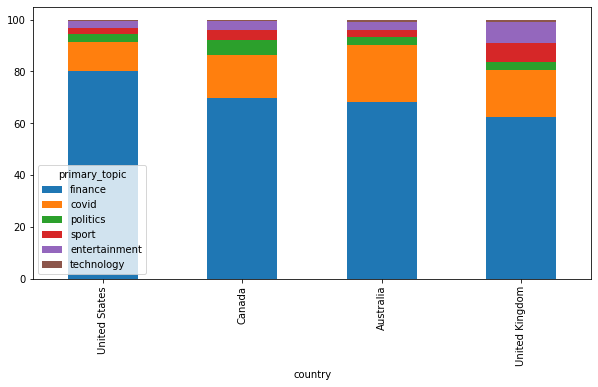

In [302]:
df_comp_chart = df_comp.pivot_table(index=['country'], columns=['primary_topic'], values='date', aggfunc='count', fill_value=0)
df_comp_chart = df_comp_chart[['finance', 'covid', 'politics', 'sport', 'entertainment', 'technology']]
df_comp_chart = df_comp_chart.div(df_comp_chart.sum(axis=1), axis=0).multiply(100)
df_comp_chart = df_comp_chart.sort_values(by="finance", ascending=False)
df_comp_chart
df_comp_chart.plot.bar(stacked=True, figsize = (10,5))

# Topics - Manual Defined

In [65]:
df_topics_manual.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,content_lemma,doc_embedding,blockchain,digitization,machine_learne,cloud,iot,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,end year corner past time think positioning fo...,"[-0.10415985, 0.034574475, -0.018250903, 0.040...",0.64344,0.492892,0.579234,0.571812,0.521615,0.453935,0.221586,0.588197,0.209348,0.51657,0.274569,0.142759,0.503211,0.464359,0.674917


In [66]:
df_topics_manual.columns

Index(['author', 'date', 'domain', 'title', 'url', 'content', 'topic_area',
       'content_processed', 'content_lemma', 'doc_embedding', 'blockchain',
       'digitization', 'machine_learne', 'cloud', 'iot', 'store_closure',
       'delivery', 'redundancy', 'costcutte', 'flight', 'supply_chain',
       'shutdown', 'outsourcing', 'workfromhome', 'diversification'],
      dtype='object')

In [67]:
df_combined.head(1)

,author,date,domain,title,url,content,topic_area,content_processed,distilbert,finbert,roberta,sentiment_match,sentiment,topic_id,topic_label,topic_label_str,topic_score,topic_words,primary_topic,filtered_names_match,nb_companies,blockchain,digitization,machine_learne,cloud,iot,store_closure,delivery,redundancy,costcutte,flight,supply_chain,shutdown,outsourcing,workfromhome,diversification,nb_comp_0
0,Thomas Hughes,2020-01-02,marketbeat,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,With the end of the year just around the corne...,business,end year corner past time think positioning fo...,POSITIVE,NEUTRAL,POSITIVE,False,POSITIVE,970,,,0.437342,"[caterpillar, ibe, fourthquarter, secondquarte...",,"[Caterpillar Inc., Cummins Inc., Deere & Compa...",5,0.64344,0.492892,0.579234,0.571812,0.521615,0.453935,0.221586,0.588197,0.209348,0.51657,0.274569,0.142759,0.503211,0.464359,0.674917,0


sentiment,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
Microsoft Corporation,7,39,46,0.85,MSFT,0.38
"Nasdaq, Inc.",7,25,32,0.78,NDAQ,0.18
"Healthcare Services Group, Inc.",6,18,24,0.75,HCSG,0.31
"Information Services Group, Inc.",8,13,21,0.62,III,0.31
Oracle Corporation,1,16,17,0.94,ORCL,0.17
"Cisco Systems, Inc.",1,12,13,0.92,CSCO,0.00
"VMware, Inc.",1,10,11,0.91,VMW,-0.07
Hewlett Packard Enterprise Company,2,9,11,0.82,HPE,-0.07
"SMART Global Holdings, Inc.",3,8,11,0.73,SGH,0.23


correlation:  -0.5387120901868132


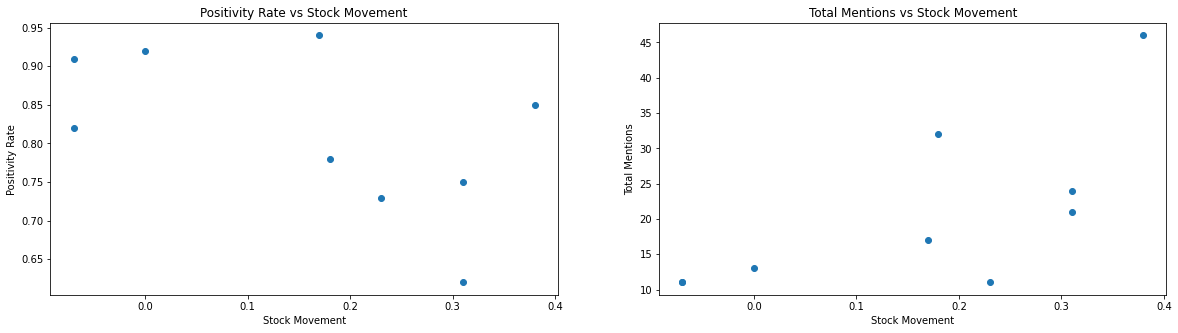

In [75]:
topic = 'digitization'
df_top_sent = df_combined.sort_values(by=topic)[:500]
df_top_sent = df_top_sent.explode('filtered_names_match')
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

print('correlation: ', np.corrcoef(df_top_sent['POS_%'], df_top_sent['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent)
#ax2.set_ylim(bottom=0, top=100)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

sentiment,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
Microsoft Corporation,10,53,63,0.84,MSFT,0.38
"Nasdaq, Inc.",9,28,37,0.76,NDAQ,0.18
Oracle Corporation,7,28,35,0.80,ORCL,0.17
"Healthcare Services Group, Inc.",8,25,33,0.76,HCSG,0.31
International Business Machines Corporation,5,15,20,0.75,IBM,-0.13
Honeywell International Inc.,4,13,17,0.76,HON,0.15
Intel Corporation,4,13,17,0.76,INTC,-0.11
"SMART Global Holdings, Inc.",3,13,16,0.81,SGH,0.23
Hewlett Packard Enterprise Company,3,12,15,0.80,HPE,-0.07


correlation:  0.28134417768846787


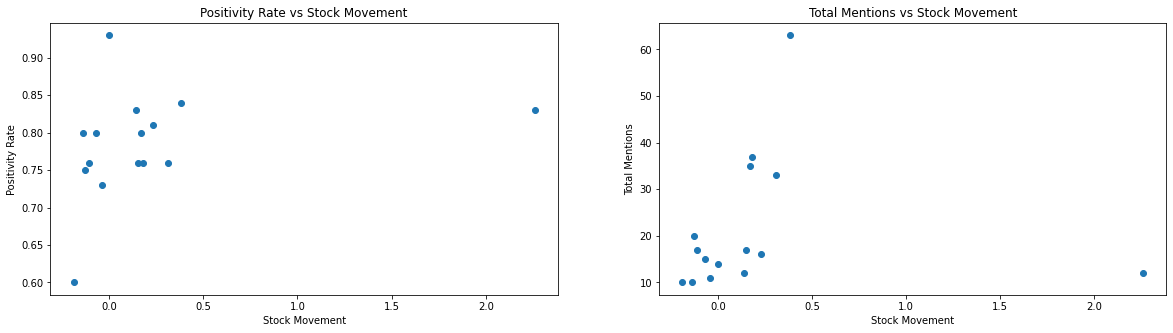

In [76]:
topic = 'iot'
df_top_sent = df_combined.sort_values(by=topic)[:500]
df_top_sent = df_top_sent.explode('filtered_names_match')
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

print('correlation: ', np.corrcoef(df_top_sent['POS_%'], df_top_sent['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent)
#ax2.set_ylim(bottom=0, top=100)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

sentiment,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
Visa Inc.,18,23,41,0.56,V,-0.02
Apple Inc.,18,19,37,0.51,AAPL,0.72
"PayPal Holdings, Inc.",21,14,35,0.40,PYPL,1.06
"The Goldman Sachs Group, Inc.",17,13,30,0.43,GS,0.17
"Nasdaq, Inc.",14,15,29,0.52,NDAQ,0.18
Mastercard Incorporated,13,12,25,0.48,MA,0.01
JPMorgan Chase & Co.,12,5,17,0.29,JPM,0.01
Microsoft Corporation,11,6,17,0.35,MSFT,0.38
SPX Corporation,8,8,16,0.50,SPXC,0.05


correlation:  0.2100040584260255


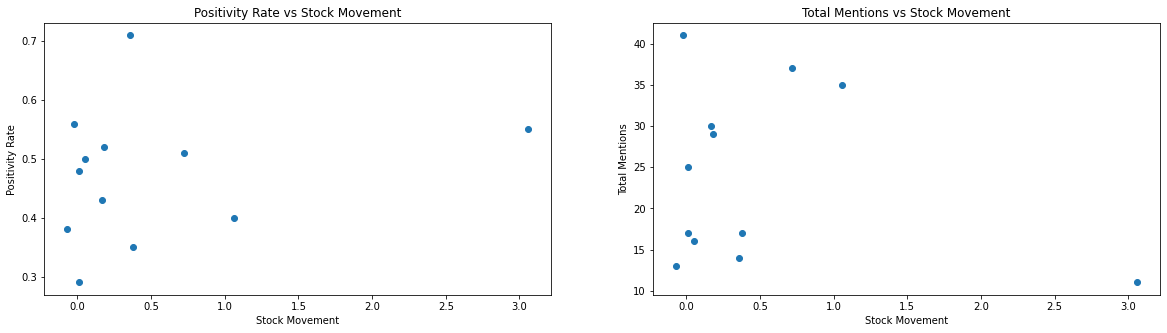

In [77]:
topic = 'blockchain'
df_top_sent = df_combined.sort_values(by=topic)[:500]
df_top_sent = df_top_sent.explode('filtered_names_match')
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

print('correlation: ', np.corrcoef(df_top_sent['POS_%'], df_top_sent['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent)
#ax2.set_ylim(bottom=0, top=100)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

sentiment,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
Apple Inc.,71,29,100,0.29,AAPL,0.72
Honeywell International Inc.,7,18,25,0.72,HON,0.15
General Motors Company,13,10,23,0.43,GM,0.54
Intel Corporation,13,5,18,0.28,INTC,-0.11
"Tesla, Inc.",5,8,13,0.62,TSLA,5.10
Ford Motor Company,9,4,13,0.31,F,0.21
The Boeing Company,5,6,11,0.55,BA,-0.39


correlation:  0.3435906899604749


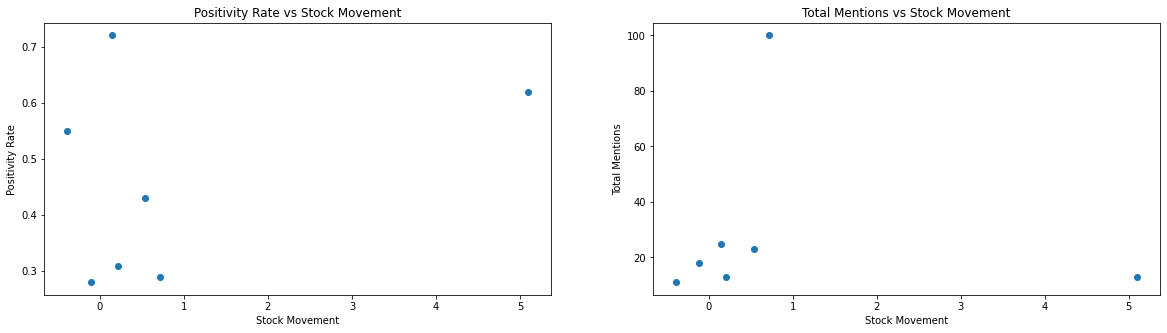

In [125]:
topic = 'supply_chain'
df_top_sent = df_combined.sort_values(by=topic)[:1000]
df_top_sent = df_top_sent.explode('filtered_names_match')
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

print('correlation: ', np.corrcoef(df_top_sent['POS_%'], df_top_sent['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent)
#ax2.set_ylim(bottom=0, top=100)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

sentiment,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
Microsoft Corporation,43,52,95,0.55,MSFT,0.38
"Nasdaq, Inc.",11,24,35,0.69,NDAQ,0.18
"Zoom Video Communications, Inc.",8,21,29,0.72,ZM,3.88
Apple Inc.,6,18,24,0.75,AAPL,0.72
Vonage Holdings Corp.,3,17,20,0.85,VG,0.41
"VMware, Inc.",7,13,20,0.65,VMW,-0.07
"Healthcare Services Group, Inc.",4,13,17,0.76,HCSG,0.31
Intel Corporation,7,10,17,0.59,INTC,-0.11
"Gartner, Inc.",4,11,15,0.73,IT,-0.06


correlation:  0.12882813548709465


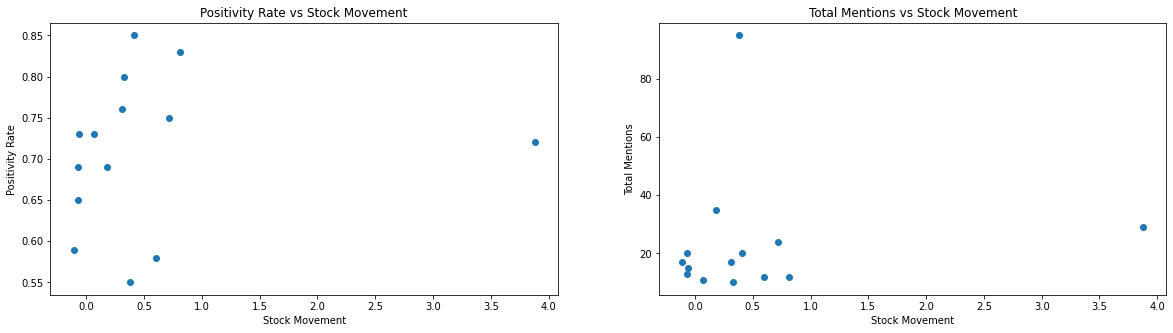

In [129]:
topic = 'workfromhome'
df_top_sent = df_combined.sort_values(by=topic)[:500]
df_top_sent = df_top_sent.explode('filtered_names_match')
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

print('correlation: ', np.corrcoef(df_top_sent['POS_%'], df_top_sent['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent)
#ax2.set_ylim(bottom=0, top=100)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()

sentiment,NEGATIVE,POSITIVE,Total,POS_%,ticker,stock_mvmt
filtered_names_match,,,,,,
Microsoft Corporation,14,56,70,0.80,MSFT,0.38
Oracle Corporation,9,39,48,0.81,ORCL,0.17
International Business Machines Corporation,11,30,41,0.73,IBM,-0.13
"Healthcare Services Group, Inc.",9,27,36,0.75,HCSG,0.31
Honeywell International Inc.,7,18,25,0.72,HON,0.15
"Nasdaq, Inc.",9,12,21,0.57,NDAQ,0.18
"Cisco Systems, Inc.",2,17,19,0.89,CSCO,0.00
Intel Corporation,3,14,17,0.82,INTC,-0.11
General Electric Company,5,12,17,0.71,GE,-0.14


correlation:  0.37004476532782415


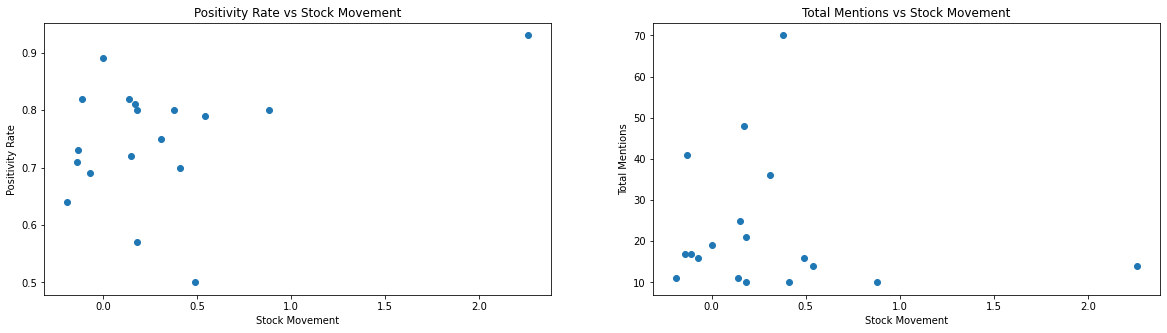

In [130]:
topic = 'outsourcing'
df_top_sent = df_combined.sort_values(by=topic)[:500]
df_top_sent = df_top_sent.explode('filtered_names_match')
df_top_sent = df_top_sent[df_top_sent['filtered_names_match'].notna()]
df_top_sent = df_top_sent.pivot_table(index=['filtered_names_match'], columns=['sentiment'], values='date', aggfunc='count', fill_value=0)
df_top_sent['Total'] = df_top_sent.sum(axis=1)
df_top_sent = df_top_sent.sort_values(by='Total', ascending=False)
df_top_sent['POS_%'] = round(df_top_sent['POSITIVE'] / df_top_sent['Total'],2)
df_top_sent['ticker'] =  df_top_sent.index.map(comp_ticker_dict)
df_top_sent['stock_mvmt'] = df_top_sent['ticker'].map(stock_final_mvmt_dict)
df_top_sent = df_top_sent[df_top_sent['stock_mvmt'].notna()]
df_top_sent = df_top_sent[df_top_sent['Total'] >= 10]
display(df_top_sent)

print('correlation: ', np.corrcoef(df_top_sent['POS_%'], df_top_sent['stock_mvmt']).flatten()[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(x="stock_mvmt", y="POS_%", data=df_top_sent)
ax2.scatter(x="stock_mvmt", y="Total", data=df_top_sent)
#ax2.set_ylim(bottom=0, top=100)
ax1.set_xlabel("Stock Movement")
ax2.set_xlabel("Stock Movement")
ax1.set_ylabel("Positivity Rate")
ax2.set_ylabel("Total Mentions")
ax1.set_title("Positivity Rate vs Stock Movement")
ax2.set_title("Total Mentions vs Stock Movement")
plt.show()